In [ ]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [ ]:
# path
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from train import *
from visualize_data import *
from utils import *

%cd /content/drive/My Drive/Colab Notebooks/Thesis

/content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning
/content/drive/My Drive/Colab Notebooks/Thesis


# State-Action Pair Guideline

Specify the desired state-action pair:

i.e. Before Pickup, Before Discard: Draw (bpbd_draw)

## Model Name Guideline

Specify the following parameters:

- **Data Selection**:
 - **`state-action pair`**
   - possible state-action pairs
```r
state_action_pair = {'all': 'all', # all actions
                    'bpbd': 'draw', # actions 2/3 
                    'apbd': ['discard', 'knock'], # actions 6-57, 58-109
                    'apad': 'knock_bin'}
```
 - **`model_name`**
   - name of the model based on **pruned states** and **chosen action**
 - **`numGames`**
   - Number of games used to train model
$$numGames \in [2000, 6000, 8000]$$

 - **`pruneStatesList`**
   - which states to omit when training model 
 ```r
 pruneStatesList is a list, {'currHand','topCard','deadCard','oppCard','unknownCard'}
 ```
 - **`actionChoice`**
   - which specific action to train model 
```r
actionChoice is one of {'all','draw','discard','knock'}
```
 - **`balance`** (T/F, **`default = False`**)
   - balance data by smallest class

--- 

- **Model Parameters**:

| Parameter         | Description                | Type             | Default |
| ----------------- |---------------------------:|:----------------:| -------:|
| **batch_size**    | num samples per iteration  | int              | 1000    |
| **learning_rate** | step size of model         | float            | 0.001   |
| **epoch**         | num of iterations          | int              | 100     |
| **model_fnc**     | model selection            | str              | MLP_base|
| **activation**    | model activation fcn       | str              | sig     |
| **loss**          | loss function selection    | str              | MSE     |
| **loss_weight**   | weighted loss (CELoss only)| str              | None    |
| **pre_train**     | initialize model weights   | bool             | False   |
| **model_PT**      | path to pretrained network | str (model/path) | null    |
| **device**        | device to train/test model | str (cpu/cuda)   | cpu     |
| **multi_data_pth**| extra data to train model  | dict             | { }     |

 - **`model_fnc`**
```r
# default
MLP_base = {1 Hidden Layer:
            input_size -> input_size*2 -> output_size,
            Activation (b/w Layers): 'Sigmoid' (default)
            Final Activation: 'Softmax'}
# Additional Models
MLP_2HL = {2 Hidden Layers:
            input_size -> input_size*2 -> input_size*2 -> output_size,
            Activation (b/w Layers): 'Sigmoid' (default)
            Final Activation: 'Softmax'} 
```

 - **`activation`**
```r
activation = {'sig': torch.nn.Sigmoid(), # default
             'relu': torch.nn.ReLU(),
             'tanh': torch.nn.Tanh()}
```

 - **`loss`**
```r
loss = {'MSE': torch.nn.MSELoss(), # default
        'CELoss': torch.nn.CrossEntropyLoss()} 
```

 - **`loss_weight`** (CELoss only)
```r
loss_weight = {None: np.ones(output_size), # default
            'icf': inverse class frequency,
            'log_icf': log inverse class frequency} 
```

 - **`multi_data_pth`**
```r
multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
                                  'numGames': {number of games}},
                   'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
                                   'numGames': {number of games}}
                   ...}
# where state/action are legal state_action pairs
# Example:
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000}}
```

# All

## all_states_all_actions

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_base'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=True)

loading 8000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00591928 | Train acc: 0.492790
              Val Loss: 0.00438910 |   Val acc: 0.624923
Epoch: 2 | Train Loss: 0.00398621 | Train acc: 0.673561
              Val Loss: 0.00371477 |   Val acc: 0.706677
Epoch: 3 | Train Loss: 0.00361394 | Train acc: 0.714980
              Val Loss: 0.00355776 |   Val acc: 0.716754
Epoch: 4 | Train Loss: 0.00351636 | Train acc: 0.721519
              Val Loss: 0.00348541 |   Val acc: 0.722457
Epoch: 5 | Train Loss: 0.00343291 | Train acc: 0.728152
              Val Loss: 0.00342042 |   Val acc: 0.729500
Epoch: 6 | Train Loss: 0.00335619 | Train acc: 0.733520
              Val Loss: 0.00334787 |   Val acc: 0.732535
Epoch: 7 | Train Loss: 0.00328823 | Train acc: 0.738366
              Val Loss: 0.00327546 |   Val acc: 0.738424
Epoch: 8 | Train Loss: 0.00321694 | Train acc: 0.743160
              Val Loss: 0.00319362 |   Val acc: 0.744061
Epoch: 9 | Train Loss: 0.00312764 | Train acc: 0.749416
              Val Loss: 0.00310847 |   V

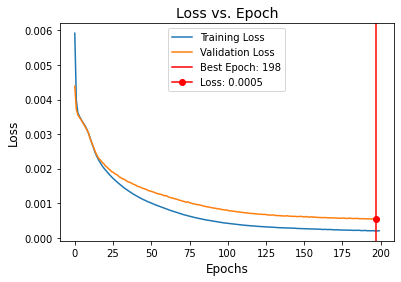

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 98.70
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 96.47
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 98.03
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 98.03
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 98.02
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.98
Normalized confusion matrix


Confusion matrix, without normalization


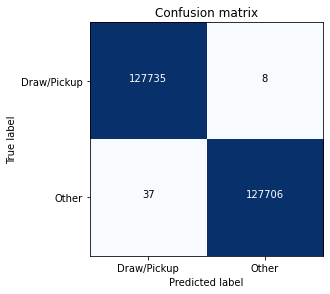

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.37
Normalized confusion matrix


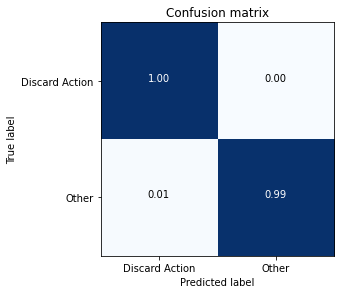

Confusion matrix, without normalization


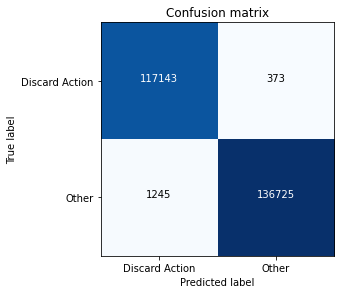

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.36
Normalized confusion matrix


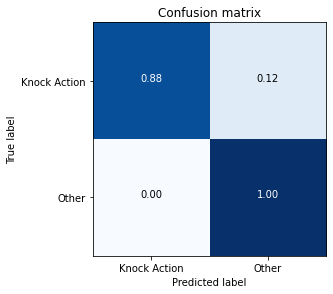

Confusion matrix, without normalization


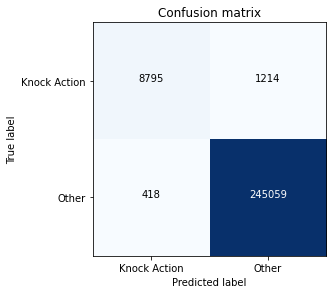

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='knock')

## all_states_all_actions_PT

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_PT'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_base'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = True
model_PT = '/content/drive/MyDrive/Colab Notebooks/Thesis/models/apbd/knock/all_states_all_actions/model.pt'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00617670 | Train acc: 0.489825
              Val Loss: 0.00471699 |   Val acc: 0.638907
Epoch: 2 | Train Loss: 0.00402308 | Train acc: 0.696065
              Val Loss: 0.00368806 |   Val acc: 0.718115
Epoch: 3 | Train Loss: 0.00348201 | Train acc: 0.731370
              Val Loss: 0.00339782 |   Val acc: 0.736114
Epoch: 4 | Train Loss: 0.00327266 | Train acc: 0.746237
              Val Loss: 0.00325119 |   Val acc: 0.747342
Epoch: 5 | Train Loss: 0.00311352 | Train acc: 0.759378
              Val Loss: 0.00310041 |   Val acc: 0.759318
Epoch: 6 | Train Loss: 0.00294300 | Train acc: 0.774490
              Val Loss: 0.00296679 |   Val acc: 0.769858
Epoch: 7 | Train Loss: 0.00279482 | Train acc: 0.787561
              Val Loss: 0.00284558 |   Val acc: 0.781286
Epoch: 8 | Train Loss: 0.00266625 | Train acc: 0.799033
              Val Loss: 0.00274750 |   Val acc: 0.787958
Epoch: 9 | Train Loss: 0.00253898 | Train acc: 0.809568
              Val Loss: 0.00264091 |   V

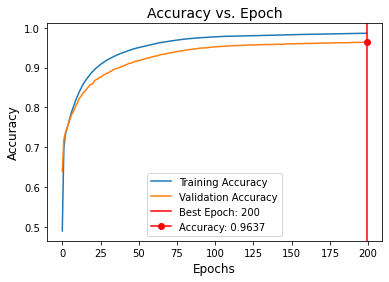

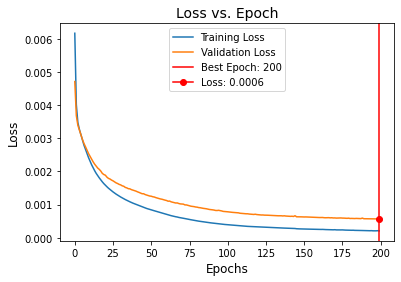

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 97.95
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 97.95
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 97.95
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.98
Normalized confusion matrix


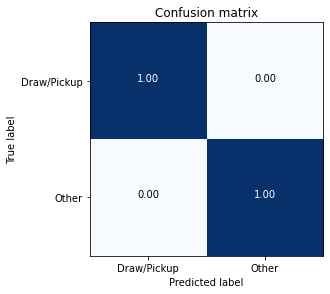

Confusion matrix, without normalization


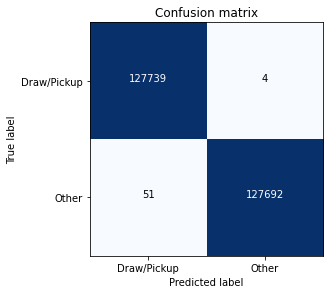

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.49
Normalized confusion matrix


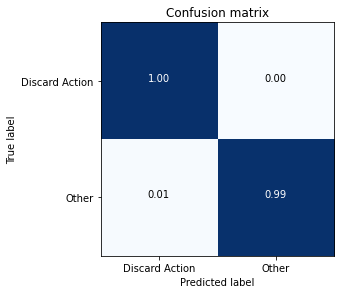

Confusion matrix, without normalization


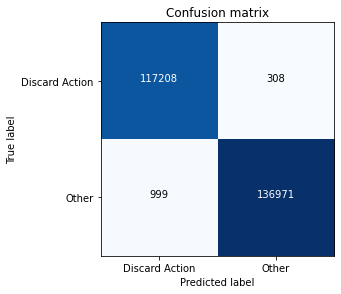

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.49
Normalized confusion matrix


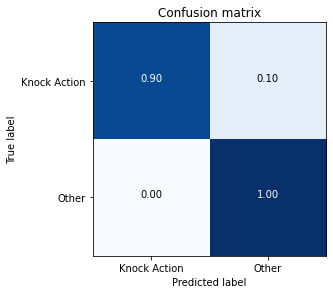

Confusion matrix, without normalization


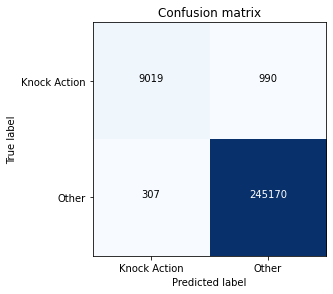

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='knock')

## all_states_all_actions CE_Loss Function, icf weighted loss 

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_CE_icf'
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.01
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_base'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'CELoss'
loss_weight = 'icf'

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 4.64417910 | Train acc: 0.084229
              Val Loss: 4.61526632 |   Val acc: 0.114881
Epoch: 2 | Train Loss: 4.60183956 | Train acc: 0.125998
              Val Loss: 4.58585119 |   Val acc: 0.140517
Epoch: 3 | Train Loss: 4.57505370 | Train acc: 0.154806
              Val Loss: 4.56135654 |   Val acc: 0.166477
Epoch: 4 | Train Loss: 4.55131068 | Train acc: 0.178375
              Val Loss: 4.53805304 |   Val acc: 0.188805
Epoch: 5 | Train Loss: 4.53032796 | Train acc: 0.198112
              Val Loss: 4.52378893 |   Val acc: 0.199971
Epoch: 6 | Train Loss: 4.51392322 | Train acc: 0.211151
              Val Loss: 4.50477457 |   Val acc: 0.211521
Epoch: 7 | Train Loss: 4.49853824 | Train acc: 0.219851
              Val Loss: 4.48954010 |   Val acc: 0.220648
Epoch: 8 | Train Loss: 4.48535293 | Train acc: 0.226937
              Val Loss: 4.47679853 |   Val acc: 0.224260
Epoch: 9 | Train Loss: 4.47129530 | Train acc: 0.230337
              Val Loss: 4.46568012 |   V

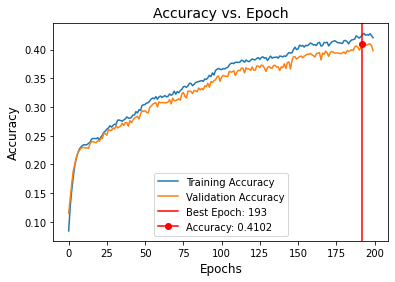

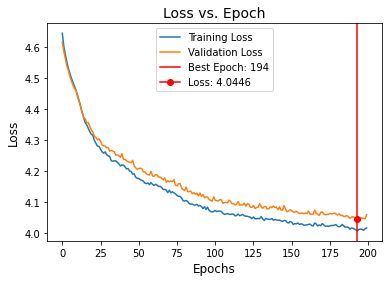

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 41.17
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 42.43
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 42.29
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 50.00
Normalized confusion matrix


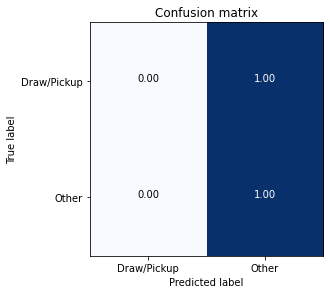

Confusion matrix, without normalization


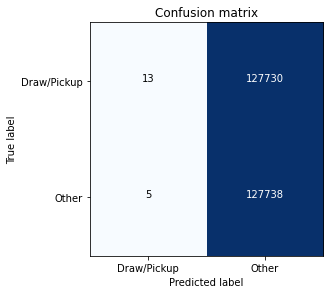

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 65.34
Normalized confusion matrix


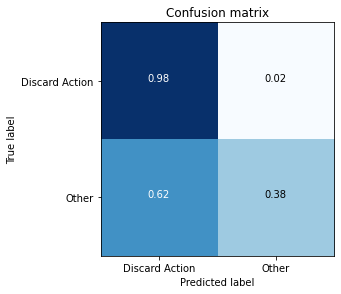

Confusion matrix, without normalization


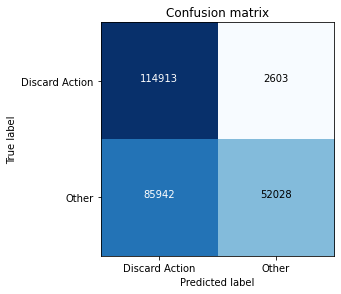

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 81.98
Normalized confusion matrix


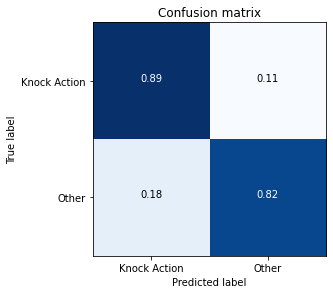

Confusion matrix, without normalization


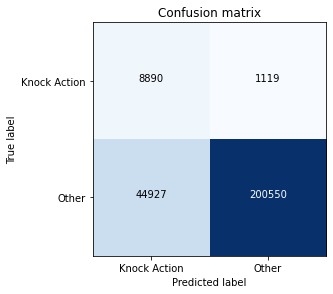

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='knock')

## all_states_all_actions CE_Loss Function, log_icf weighted loss 

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_CE_log_icf'
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 100

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_base'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'CELoss'
loss_weight = 'log_icf'

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 4.36903330 | Train acc: 0.414993
              Val Loss: 4.36569023 |   Val acc: 0.416195
Epoch: 2 | Train Loss: 4.36390429 | Train acc: 0.418369
              Val Loss: 4.36568928 |   Val acc: 0.416195
Epoch: 3 | Train Loss: 4.36391115 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 4 | Train Loss: 4.36390600 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 5 | Train Loss: 4.36390326 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 6 | Train Loss: 4.36390737 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 7 | Train Loss: 4.36391458 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 8 | Train Loss: 4.36390703 | Train acc: 0.418369
              Val Loss: 4.36568689 |   Val acc: 0.416195
Epoch: 9 | Train Loss: 4.36391355 | Train acc: 0.418369
              Val Loss: 4.36568689 |   V

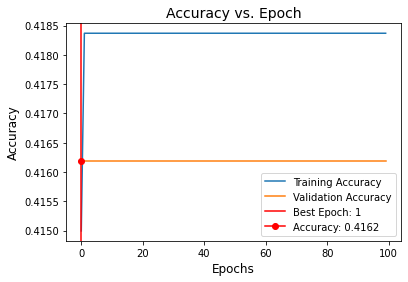

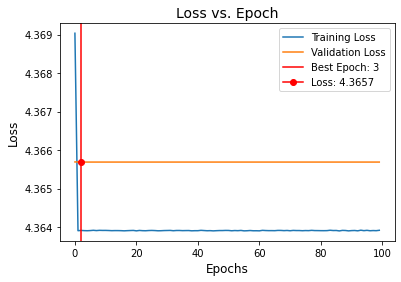

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 41.77
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 41.77
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 41.77
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 50.00
Normalized confusion matrix


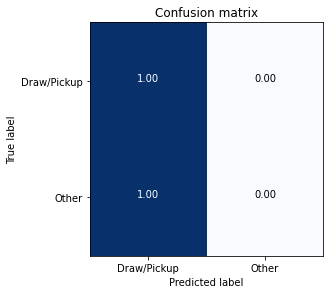

Confusion matrix, without normalization


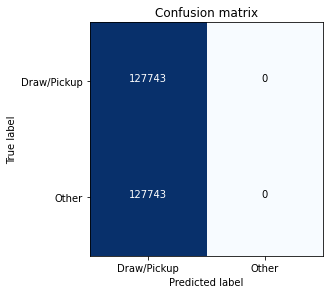

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 54.00
Normalized confusion matrix


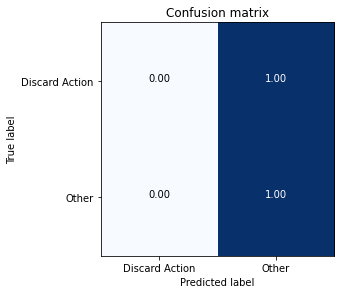

Confusion matrix, without normalization


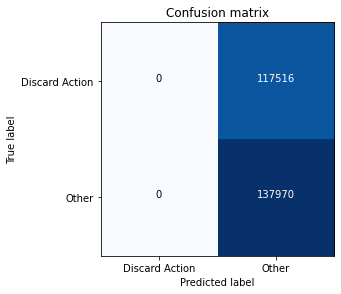

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 96.08
Normalized confusion matrix


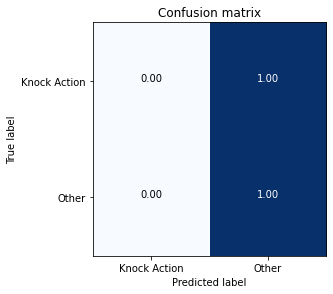

Confusion matrix, without normalization


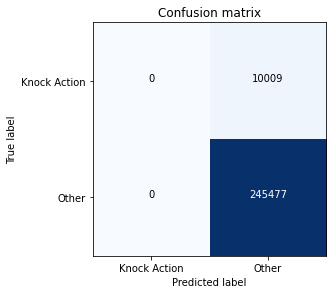

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='knock')

## all_states_all_actions_2HL

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_2hl'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_2HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00637100 | Train acc: 0.421942
              Val Loss: 0.00563129 |   Val acc: 0.427554
Epoch: 2 | Train Loss: 0.00557441 | Train acc: 0.450407
              Val Loss: 0.00551973 |   Val acc: 0.480595
Epoch: 3 | Train Loss: 0.00468898 | Train acc: 0.589882
              Val Loss: 0.00412690 |   Val acc: 0.648343
Epoch: 4 | Train Loss: 0.00388505 | Train acc: 0.675245
              Val Loss: 0.00369159 |   Val acc: 0.696009
Epoch: 5 | Train Loss: 0.00358062 | Train acc: 0.707981
              Val Loss: 0.00350355 |   Val acc: 0.714768
Epoch: 6 | Train Loss: 0.00341682 | Train acc: 0.722136
              Val Loss: 0.00339903 |   Val acc: 0.722238
Epoch: 7 | Train Loss: 0.00327459 | Train acc: 0.733683
              Val Loss: 0.00324543 |   Val acc: 0.737454
Epoch: 8 | Train Loss: 0.00313077 | Train acc: 0.745983
              Val Loss: 0.00309185 |   Val acc: 0.745267
Epoch: 9 | Train Loss: 0.00294783 | Train acc: 0.761027
              Val Loss: 0.00296116 |   V

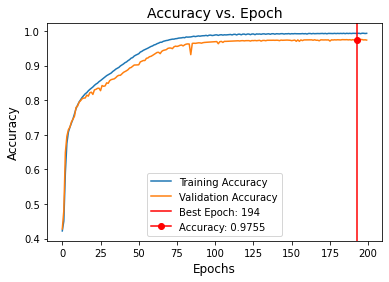

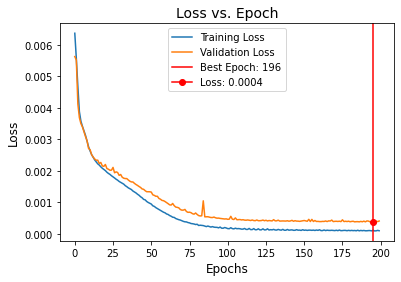

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 99.29
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 98.71
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 98.81
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 98.82
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.99
Normalized confusion matrix


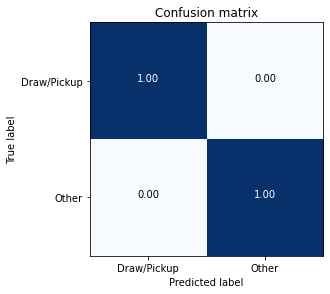

Confusion matrix, without normalization


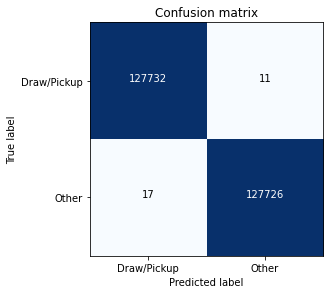

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.57
Normalized confusion matrix


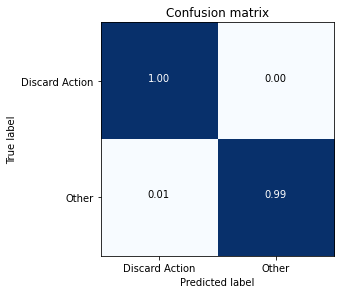

Confusion matrix, without normalization


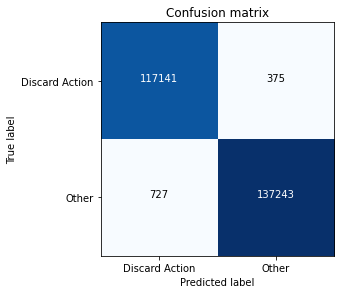

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.58
Normalized confusion matrix


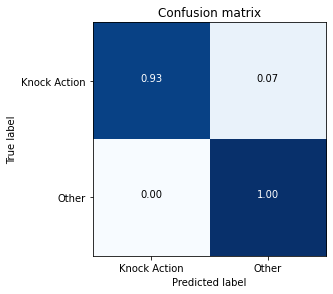

Confusion matrix, without normalization


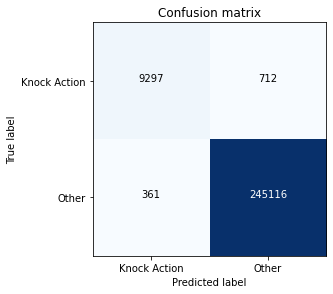

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader_2k, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, mode='knock_data_only')

Accuracy: 98.22
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (8k)

In [ ]:
currGames = 8000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader_2k, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames, mode='knock_data_only')

Accuracy: 92.00
Normalized confusion matrix
Confusion matrix, without normalization


## all_states_all_actions_2HL_extra_knock_data

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_2hl_extra_knock_data'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_2HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

loading 8000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating data_pth1 dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"


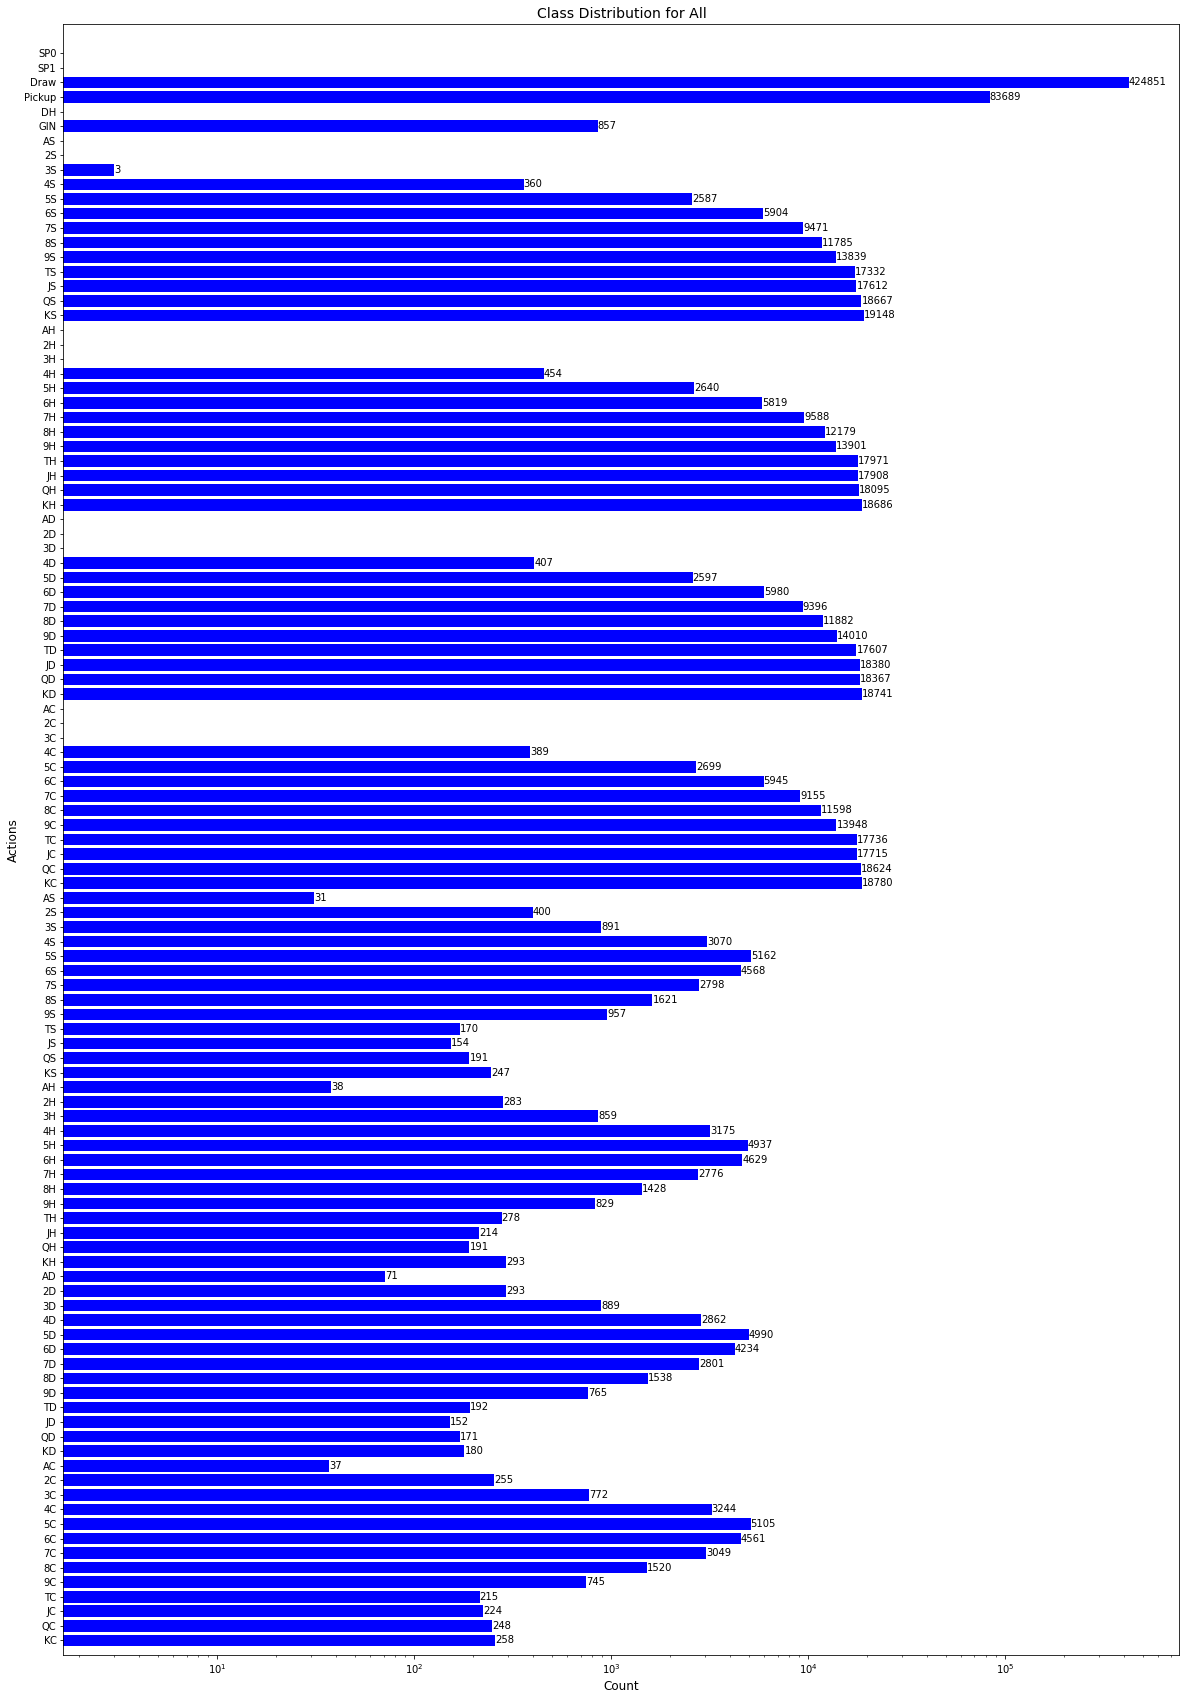

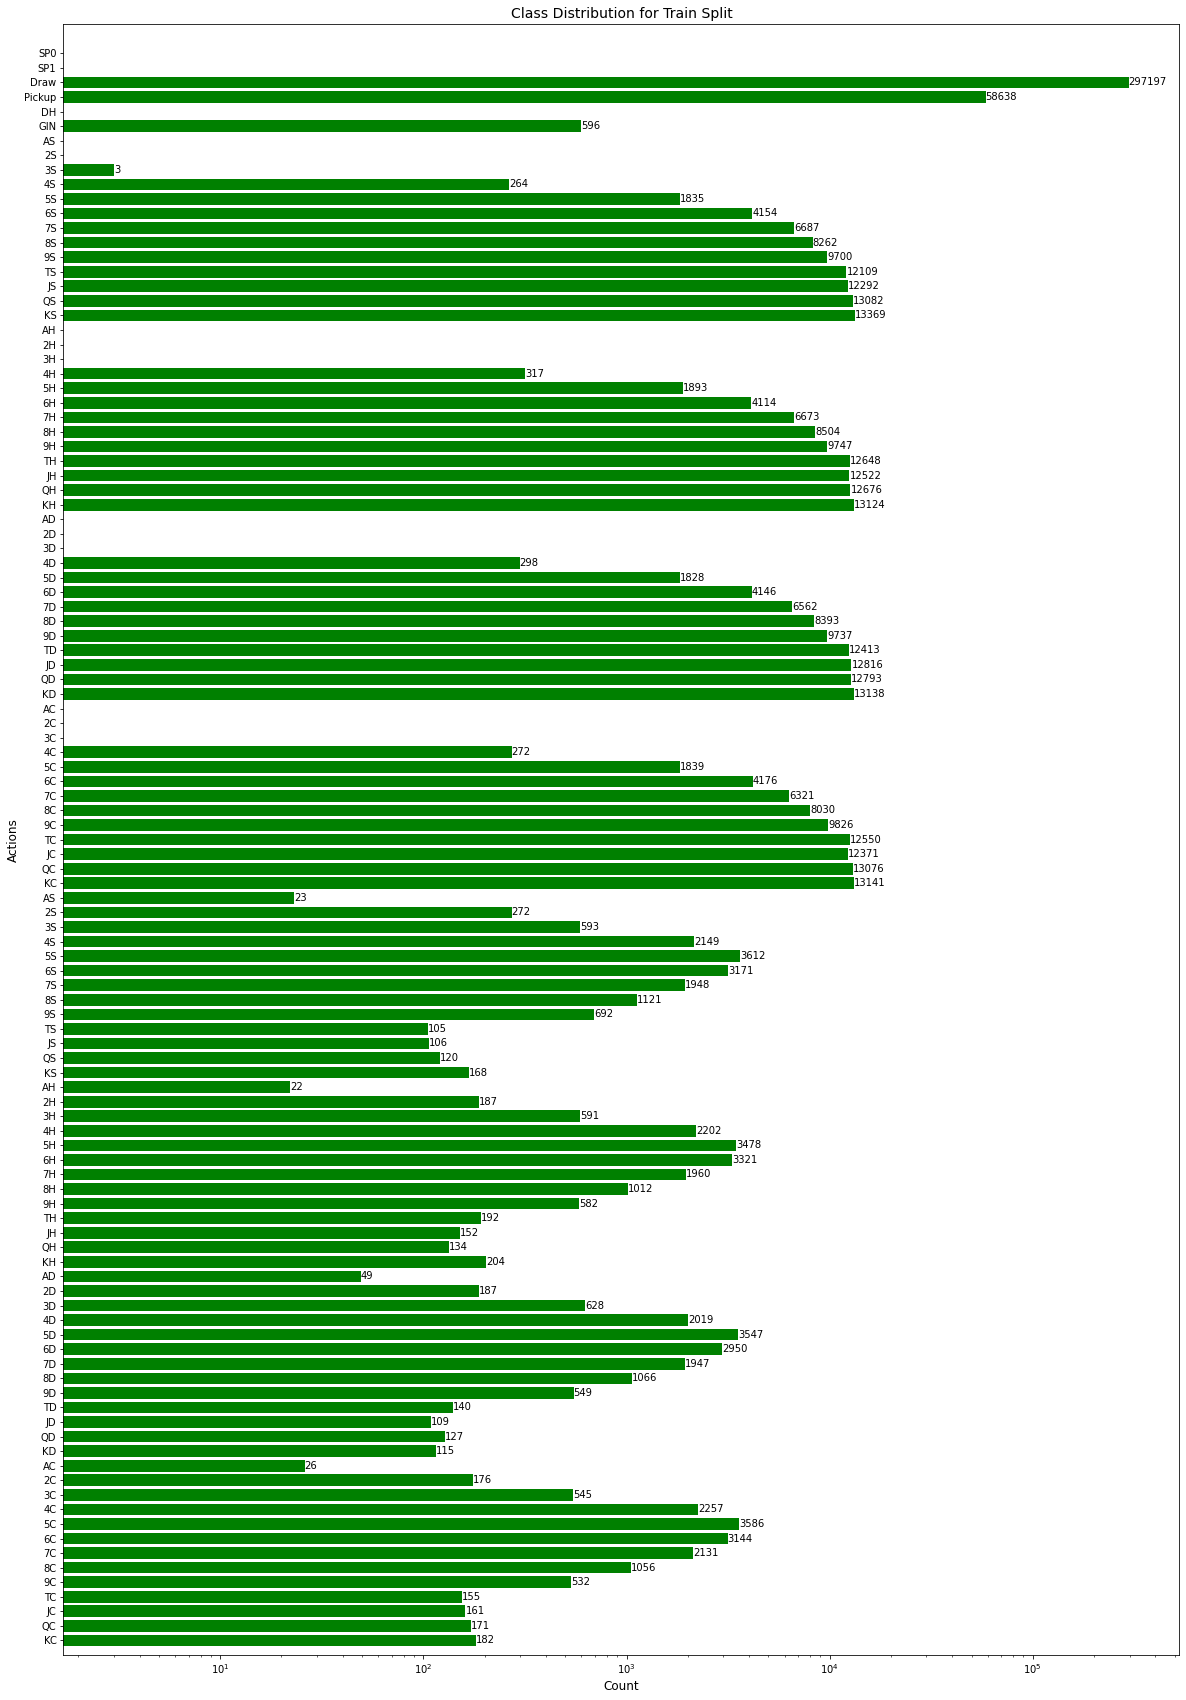

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=True)

### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00641788 | Train acc: 0.406126
              Val Loss: 0.00573890 |   Val acc: 0.417556
Epoch: 2 | Train Loss: 0.00569649 | Train acc: 0.433047
              Val Loss: 0.00558947 |   Val acc: 0.439350
Epoch: 3 | Train Loss: 0.00480970 | Train acc: 0.570323
              Val Loss: 0.00429199 |   Val acc: 0.619418
Epoch: 4 | Train Loss: 0.00407713 | Train acc: 0.649503
              Val Loss: 0.00391131 |   Val acc: 0.667756
Epoch: 5 | Train Loss: 0.00383075 | Train acc: 0.678228
              Val Loss: 0.00371306 |   Val acc: 0.689316
Epoch: 6 | Train Loss: 0.00368286 | Train acc: 0.693899
              Val Loss: 0.00359422 |   Val acc: 0.701261
Epoch: 7 | Train Loss: 0.00355787 | Train acc: 0.704366
              Val Loss: 0.00346858 |   Val acc: 0.711681
Epoch: 8 | Train Loss: 0.00341863 | Train acc: 0.716103
              Val Loss: 0.00334593 |   Val acc: 0.719989
Epoch: 9 | Train Loss: 0.00325484 | Train acc: 0.730222
              Val Loss: 0.00315670 |   V

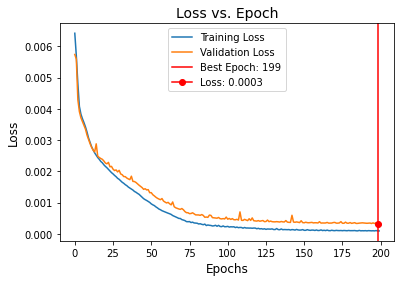

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 99.06
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 99.06
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 99.06
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.99
Normalized confusion matrix


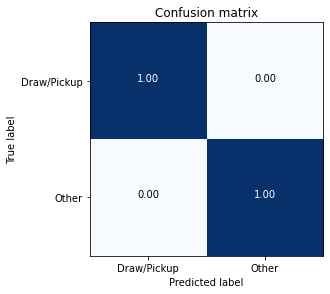

Confusion matrix, without normalization


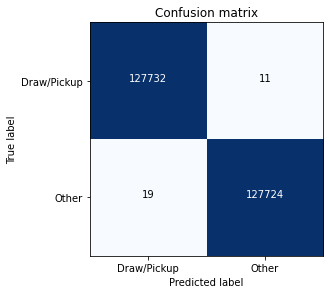

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.78
Normalized confusion matrix


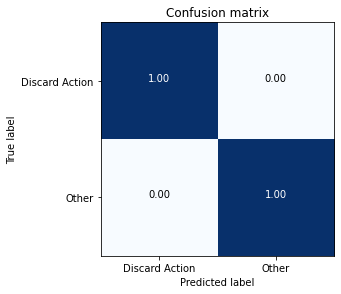

Confusion matrix, without normalization


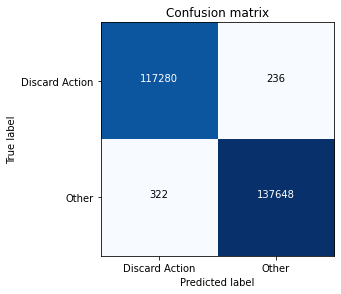

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.80
Normalized confusion matrix


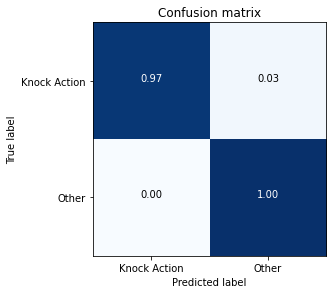

Confusion matrix, without normalization


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 98.45
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (8k)

In [ ]:
currGames = 8000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 96.87
Normalized confusion matrix
Confusion matrix, without normalization


## all_states_all_actions_2HL_extra_knock_data_40K

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_2hl_extra_knock_data_40K'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_2HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

loading 8000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998


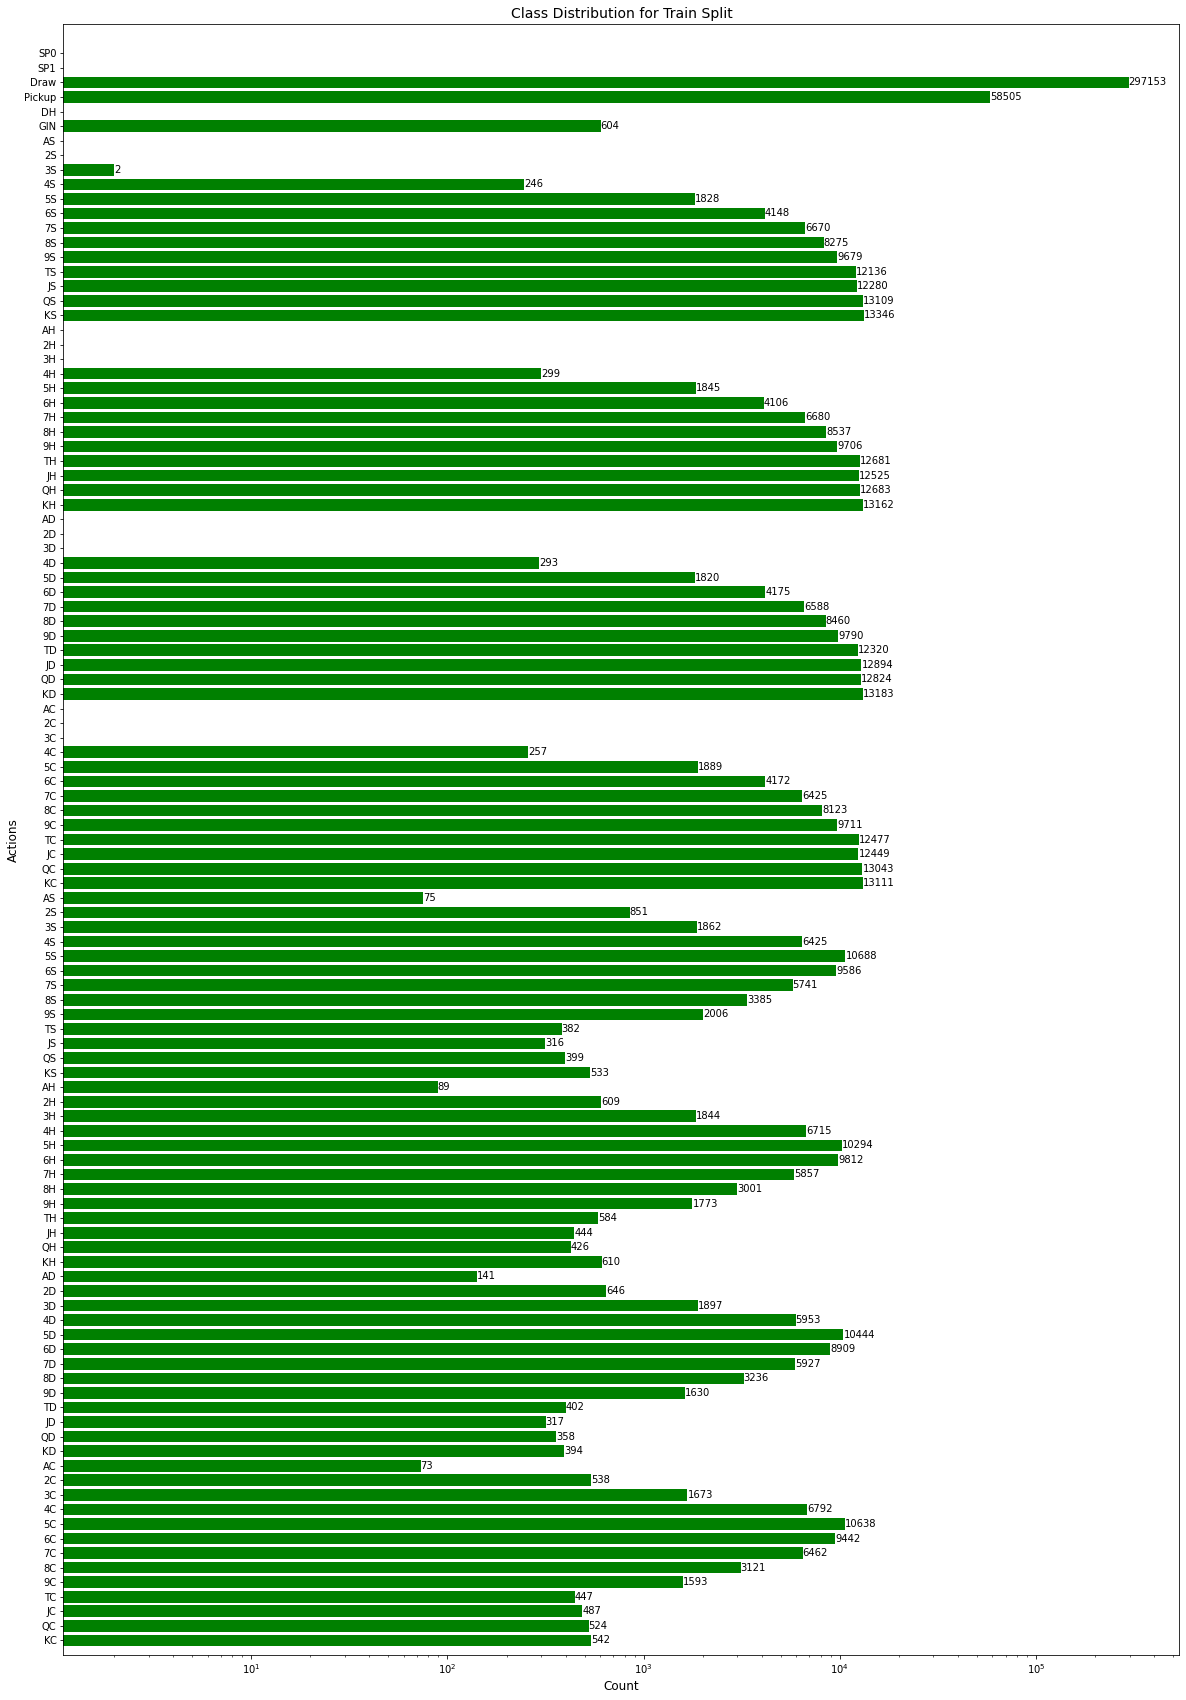

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=True)

### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00673435 | Train acc: 0.354711
              Val Loss: 0.00615824 |   Val acc: 0.371412
Epoch: 2 | Train Loss: 0.00611758 | Train acc: 0.383591
              Val Loss: 0.00601201 |   Val acc: 0.428853
Epoch: 3 | Train Loss: 0.00532244 | Train acc: 0.508947
              Val Loss: 0.00491697 |   Val acc: 0.565765
Epoch: 4 | Train Loss: 0.00469511 | Train acc: 0.591427
              Val Loss: 0.00455032 |   Val acc: 0.614844
Epoch: 5 | Train Loss: 0.00435083 | Train acc: 0.643104
              Val Loss: 0.00418646 |   Val acc: 0.661571
Epoch: 6 | Train Loss: 0.00405633 | Train acc: 0.675228
              Val Loss: 0.00394903 |   Val acc: 0.686733
Epoch: 7 | Train Loss: 0.00379643 | Train acc: 0.699770
              Val Loss: 0.00373922 |   Val acc: 0.705872
Epoch: 8 | Train Loss: 0.00350145 | Train acc: 0.725765
              Val Loss: 0.00352244 |   Val acc: 0.721838
Epoch: 9 | Train Loss: 0.00322255 | Train acc: 0.748705
              Val Loss: 0.00314746 |   V

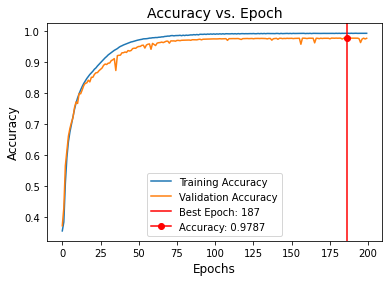

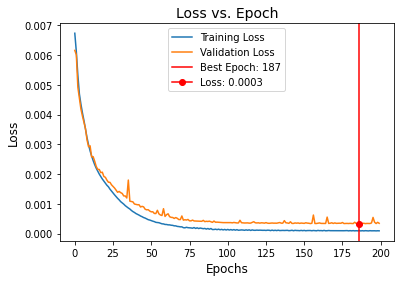

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
del val_loader
currGames = 8000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 99.42
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
del train_loader
currGames = 8000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 97.80
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 98.98
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 99.02
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 99.02
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.99
Normalized confusion matrix


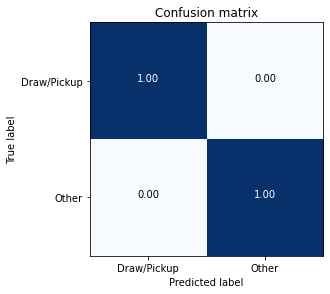

Confusion matrix, without normalization


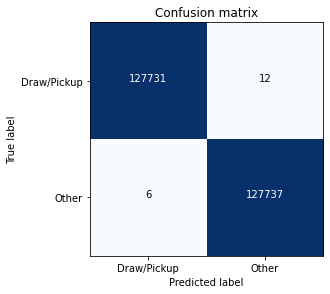

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.84
Normalized confusion matrix


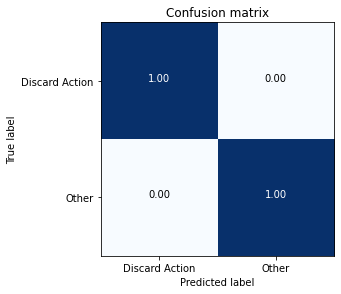

Confusion matrix, without normalization


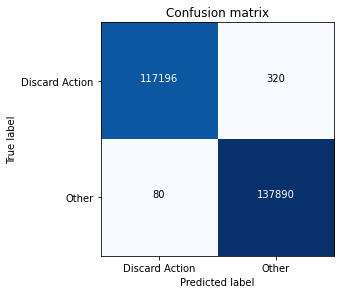

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.85
Normalized confusion matrix


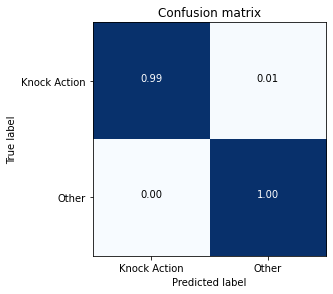

Confusion matrix, without normalization


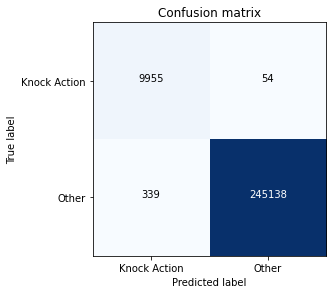

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 98.17
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (6k)

In [ ]:
currGames = 6000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

loading 6000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 99.25
Normalized confusion matrix
Confusion matrix, without normalization


## all_states_all_actions_MLP_base_extra_knock_data_40K

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_MLP_base_extra_knock_data_40K'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_base'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00648091 | Train acc: 0.412315
              Val Loss: 0.00517916 |   Val acc: 0.540861
Epoch: 2 | Train Loss: 0.00479942 | Train acc: 0.595855
              Val Loss: 0.00451519 |   Val acc: 0.639781
Epoch: 3 | Train Loss: 0.00434031 | Train acc: 0.659598
              Val Loss: 0.00421408 |   Val acc: 0.673409
Epoch: 4 | Train Loss: 0.00415876 | Train acc: 0.678355
              Val Loss: 0.00413442 |   Val acc: 0.678952
Epoch: 5 | Train Loss: 0.00404489 | Train acc: 0.687039
              Val Loss: 0.00399963 |   Val acc: 0.690908
Epoch: 6 | Train Loss: 0.00393383 | Train acc: 0.695737
              Val Loss: 0.00388337 |   Val acc: 0.699391
Epoch: 7 | Train Loss: 0.00379604 | Train acc: 0.707017
              Val Loss: 0.00374150 |   Val acc: 0.710442
Epoch: 8 | Train Loss: 0.00364798 | Train acc: 0.719666
              Val Loss: 0.00358966 |   Val acc: 0.724149
Epoch: 9 | Train Loss: 0.00347707 | Train acc: 0.735263
              Val Loss: 0.00342329 |   V

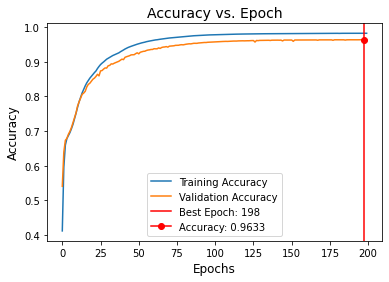

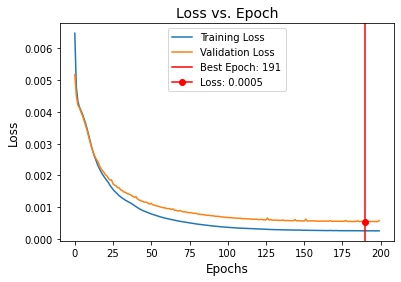

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
del val_loader
currGames = 8000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 98.13
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 98.11
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 98.21
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 98.20
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.98
Normalized confusion matrix


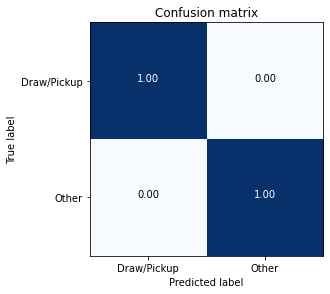

Confusion matrix, without normalization


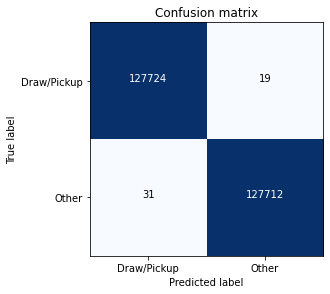

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.70
Normalized confusion matrix


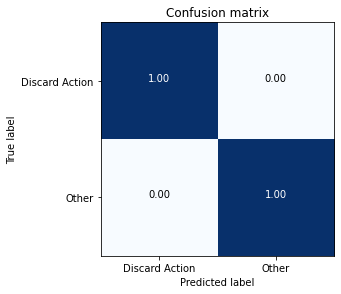

Confusion matrix, without normalization


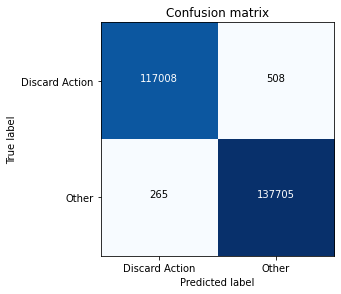

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.69
Normalized confusion matrix


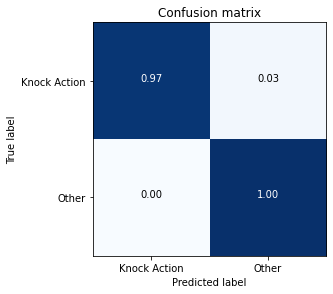

Confusion matrix, without normalization


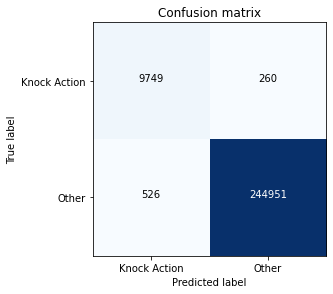

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 96.75
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (6k)

In [ ]:
currGames = 6000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

loading 6000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 95.50
Normalized confusion matrix
Confusion matrix, without normalization


## all_states_all_actions_2HL_extra_knock_data_80K

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_2hl_extra_knock_data_80K'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_2HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000},
                  'Third Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 40000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

loading 8000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998
concatenating Third Path dataset (40000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 198987


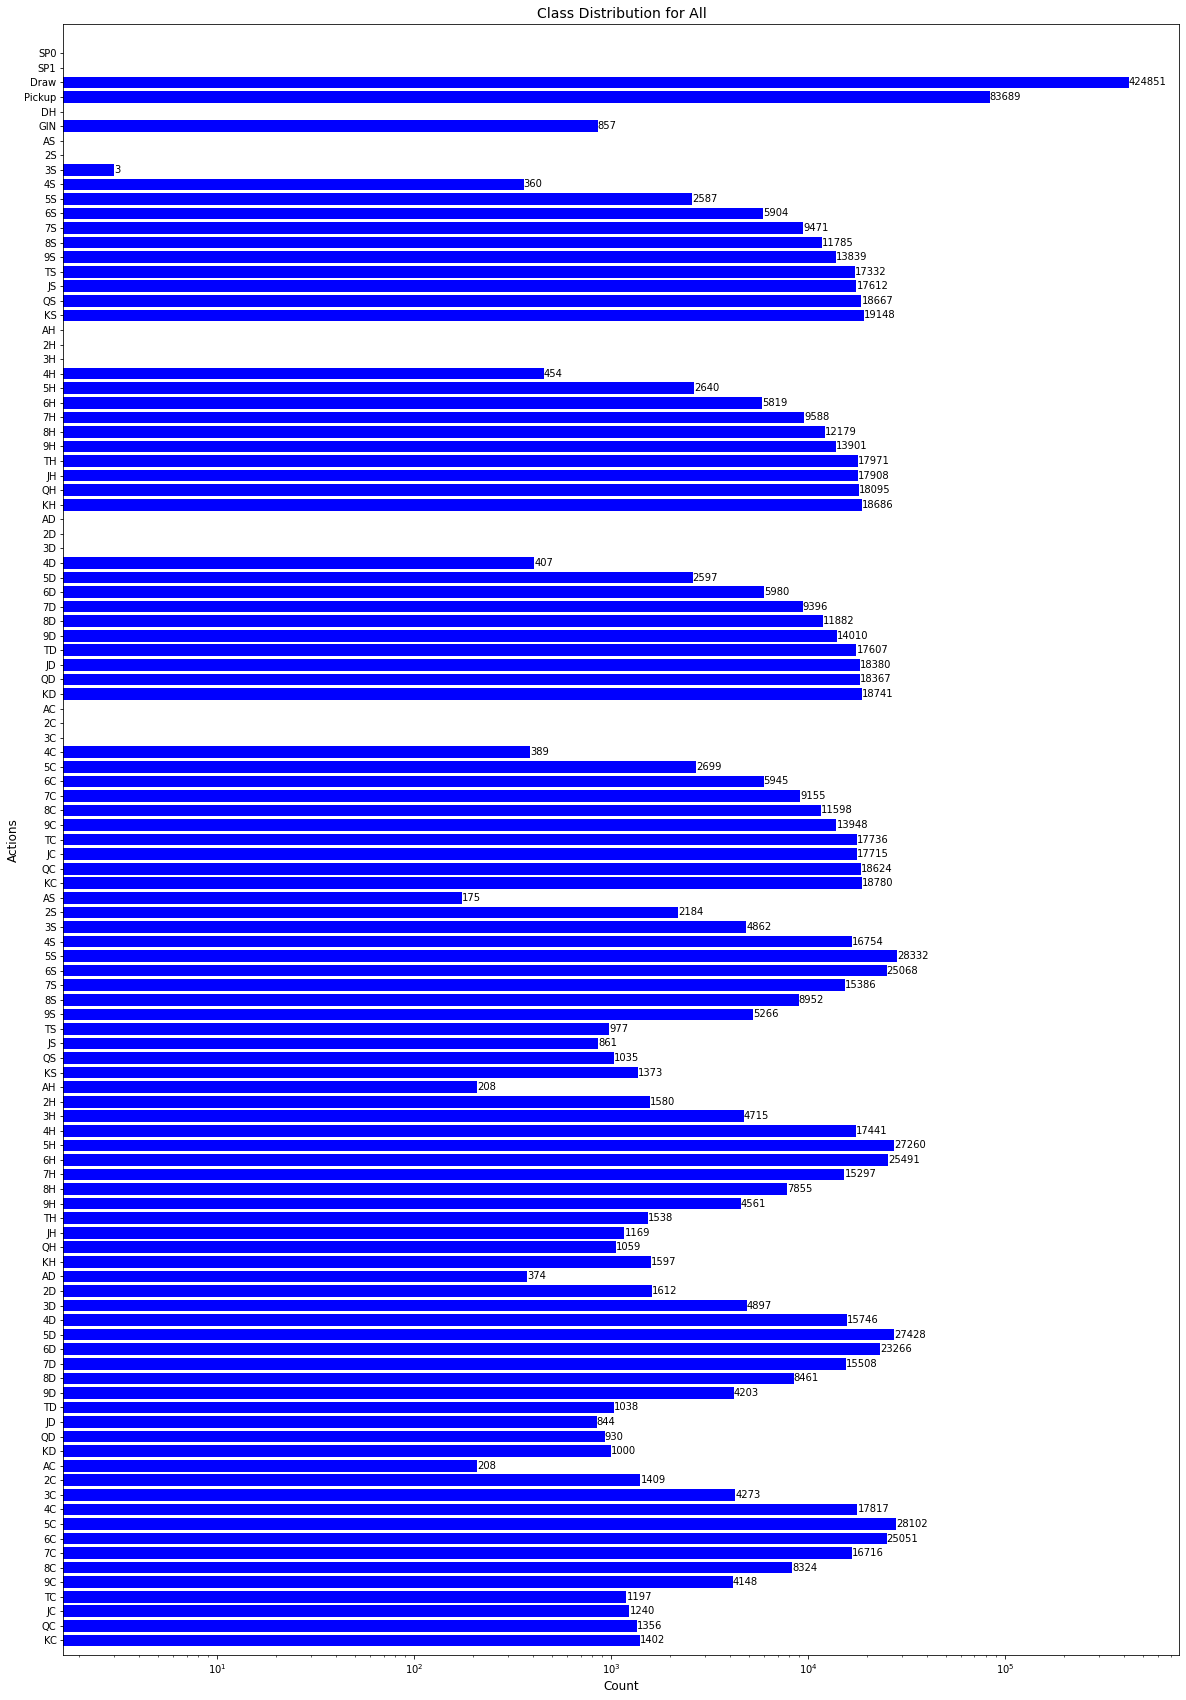

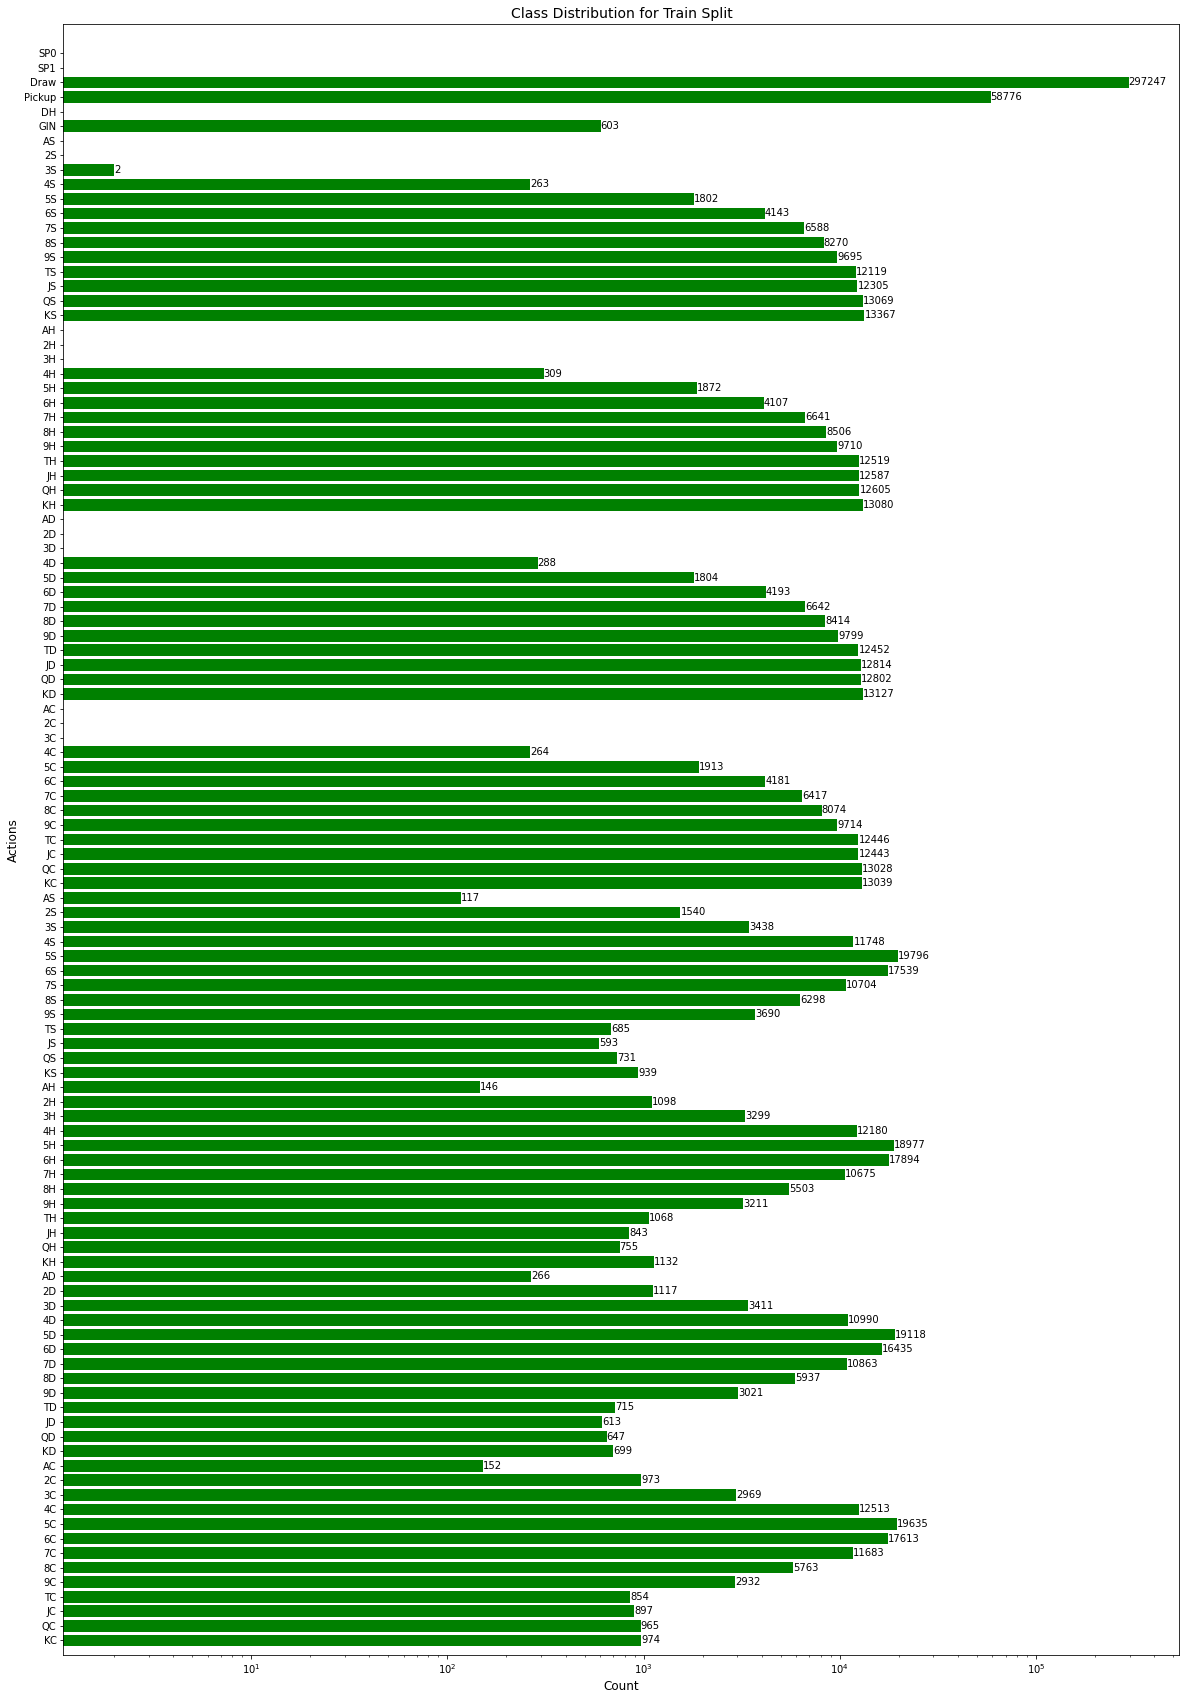

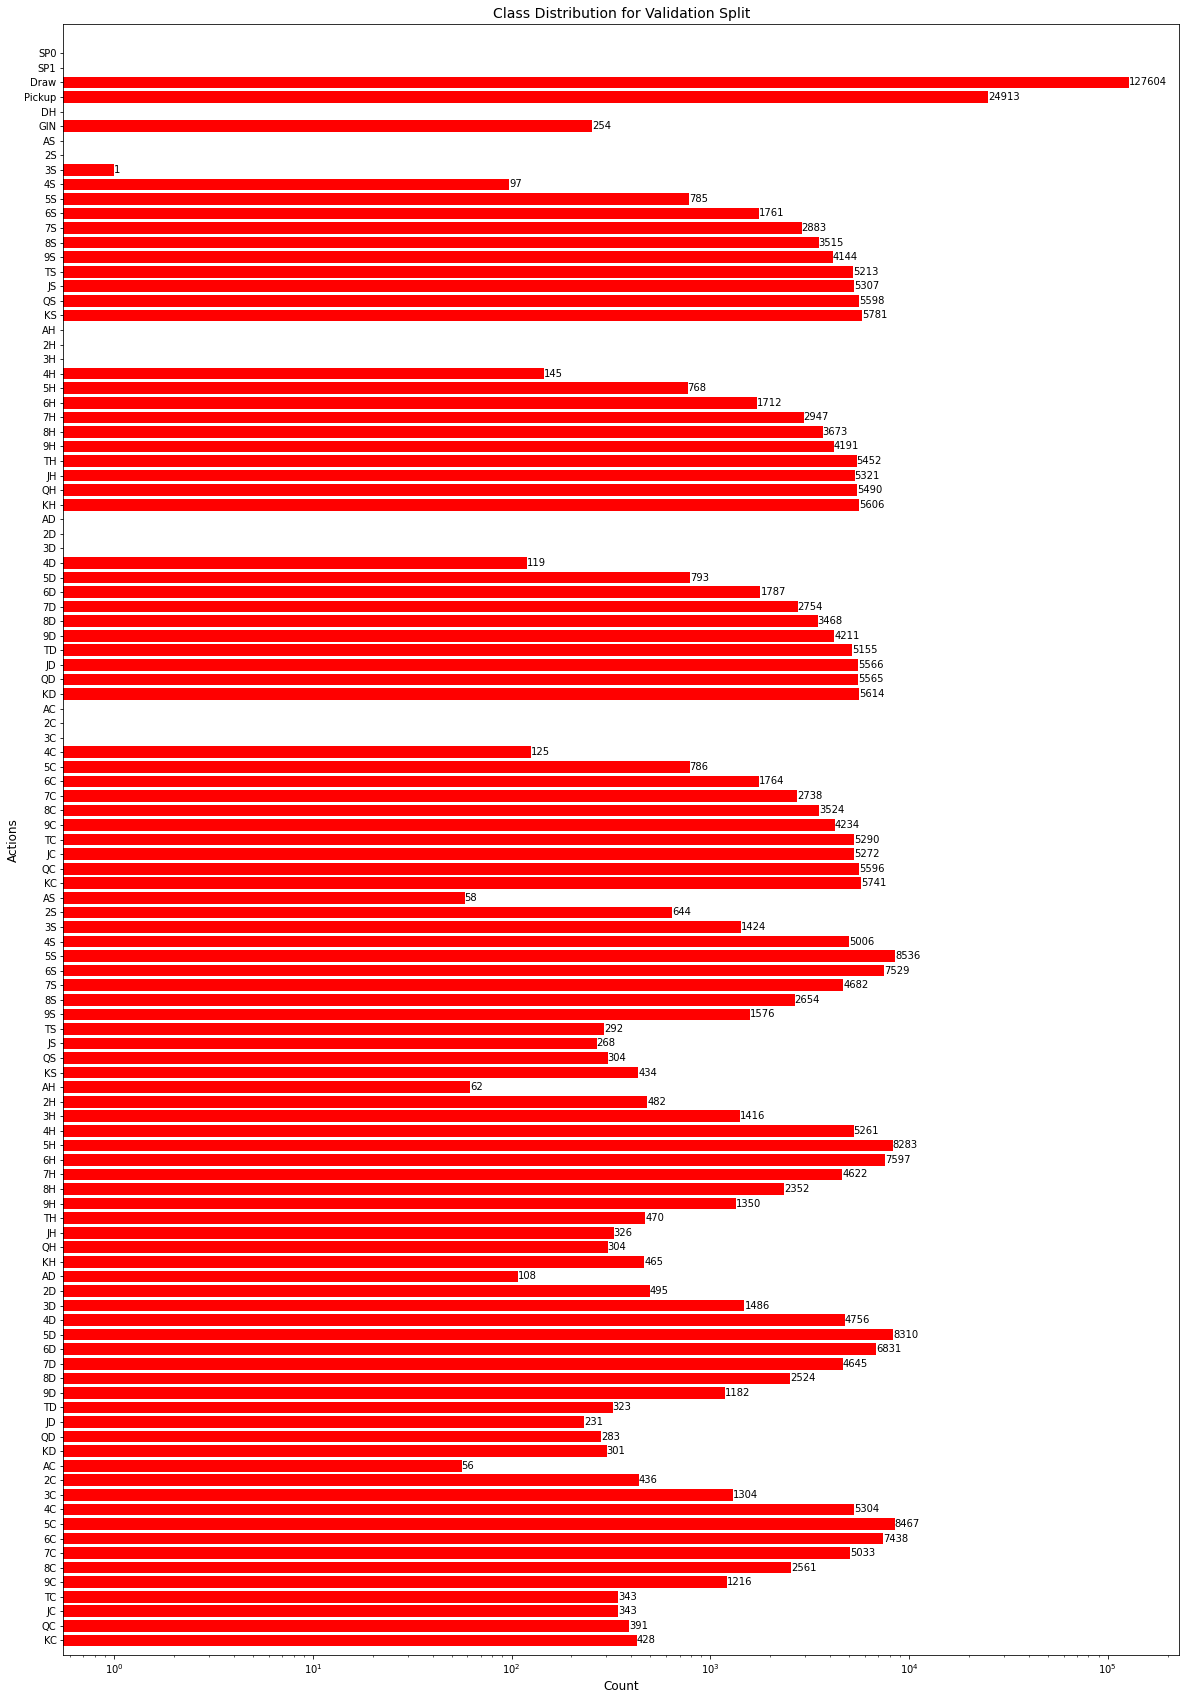

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=True)

### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00697283 | Train acc: 0.314587
              Val Loss: 0.00650826 |   Val acc: 0.342790
Epoch: 2 | Train Loss: 0.00626970 | Train acc: 0.406823
              Val Loss: 0.00595019 |   Val acc: 0.470231
Epoch: 3 | Train Loss: 0.00540212 | Train acc: 0.546536
              Val Loss: 0.00480028 |   Val acc: 0.610779
Epoch: 4 | Train Loss: 0.00447686 | Train acc: 0.644324
              Val Loss: 0.00412953 |   Val acc: 0.680487
Epoch: 5 | Train Loss: 0.00382982 | Train acc: 0.707169
              Val Loss: 0.00359983 |   Val acc: 0.725076
Epoch: 6 | Train Loss: 0.00338369 | Train acc: 0.743873
              Val Loss: 0.00322910 |   Val acc: 0.754766
Epoch: 7 | Train Loss: 0.00306980 | Train acc: 0.769388
              Val Loss: 0.00299054 |   Val acc: 0.775778
Epoch: 8 | Train Loss: 0.00279151 | Train acc: 0.790794
              Val Loss: 0.00269825 |   Val acc: 0.797034
Epoch: 9 | Train Loss: 0.00251293 | Train acc: 0.812375
              Val Loss: 0.00242340 |   V

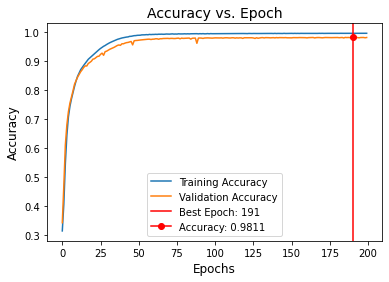

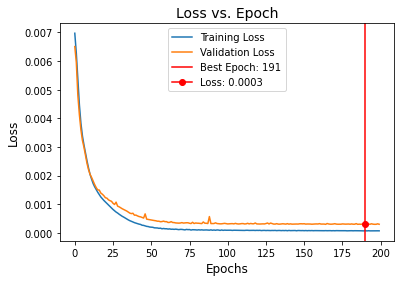

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
del val_loader
currGames = 8000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 99.55
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
del train_loader
currGames = 8000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 98.08
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 99.05
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 99.06
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 99.06
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.99
Normalized confusion matrix


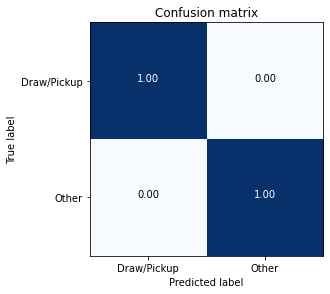

Confusion matrix, without normalization


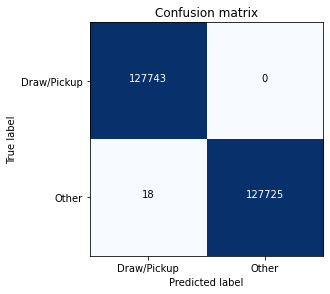

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.84
Normalized confusion matrix


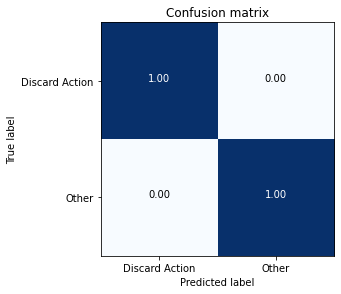

Confusion matrix, without normalization


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.84
Normalized confusion matrix


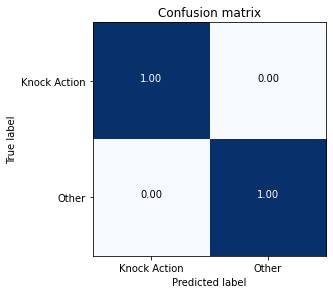

Confusion matrix, without normalization


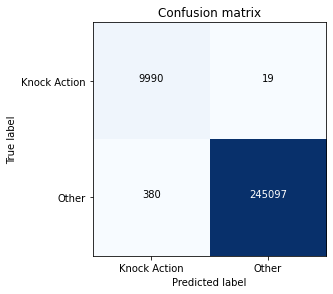

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 98.20
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (6k)

In [ ]:
currGames = 6000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

loading 6000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 99.75
Normalized confusion matrix
Confusion matrix, without normalization


## all_states_all_actions_2HL_extra_knock_data_80K_2K_base

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_2hl_extra_knock_data_80K_2K_base'

# Number of Games
numGames = 2000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_2HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000},
                  'Third Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 40000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

loading 2000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998
concatenating Third Path dataset (40000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 198987


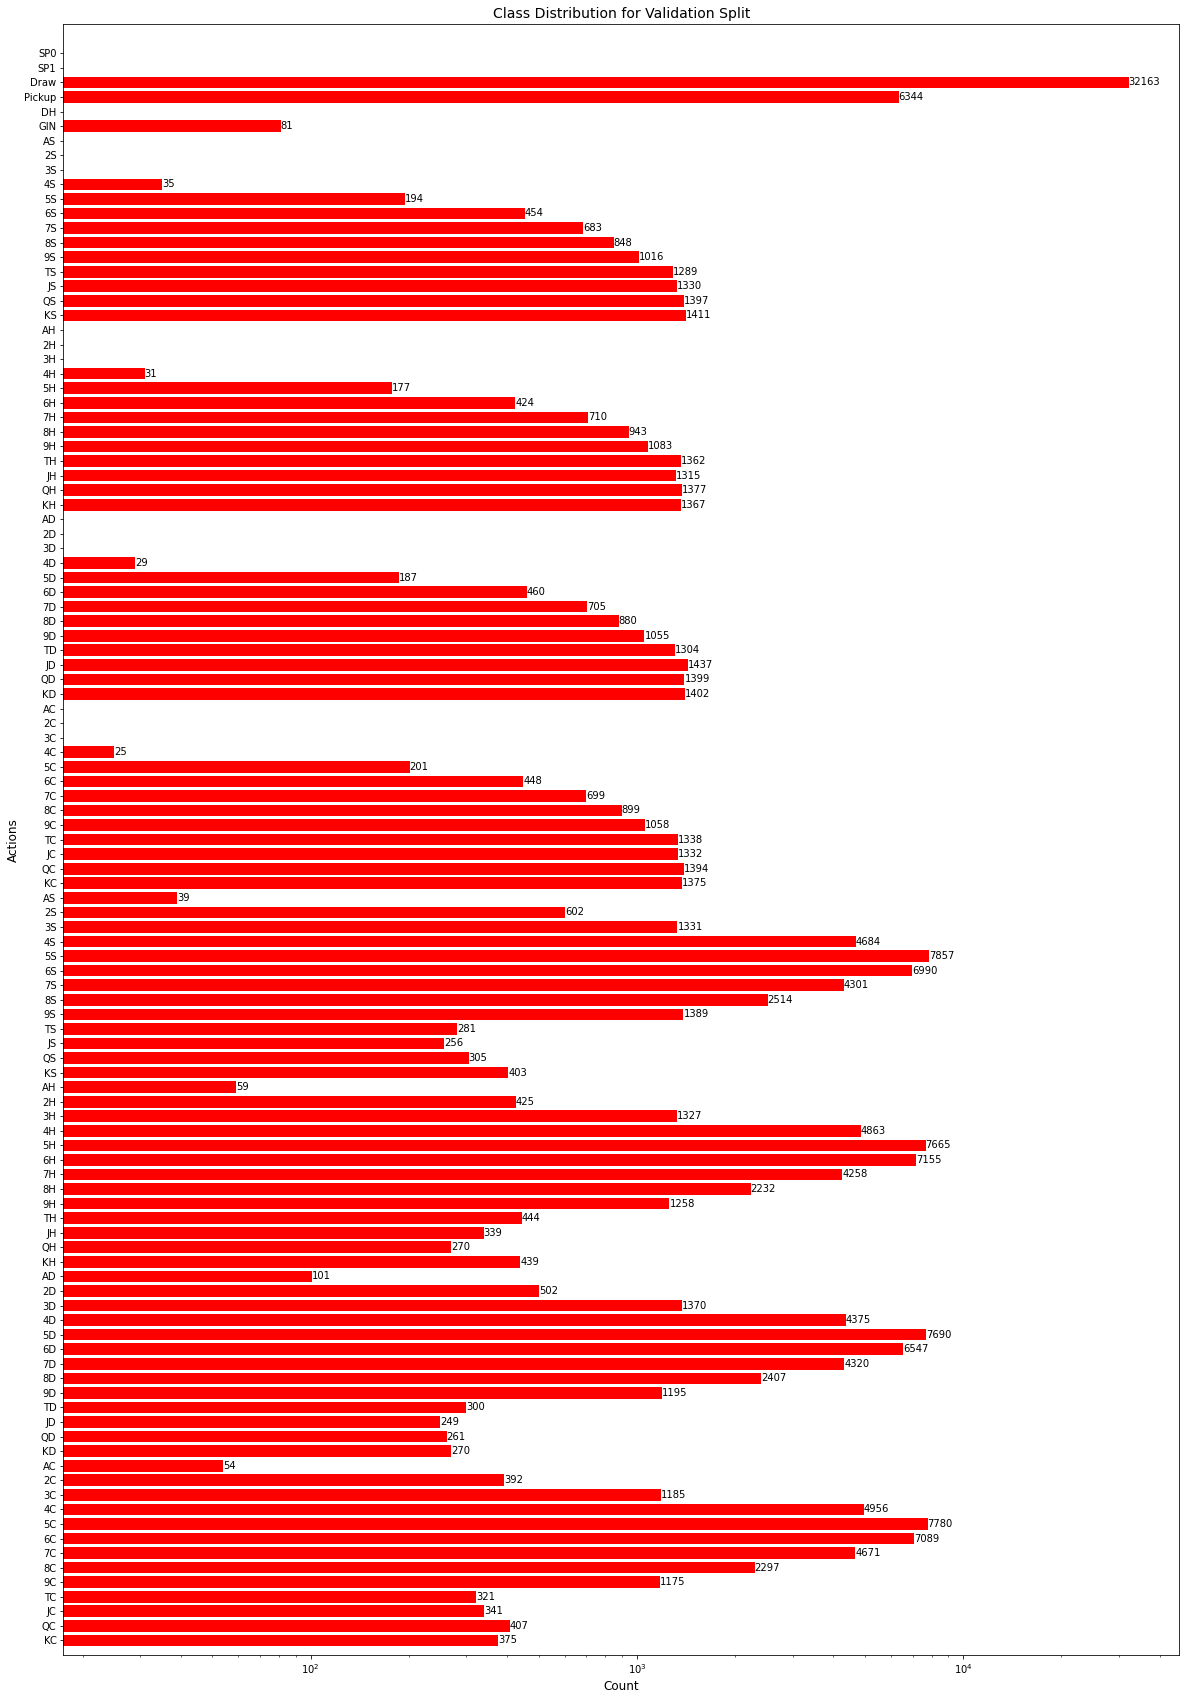

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=True)

### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00773359 | Train acc: 0.284900
              Val Loss: 0.00638633 |   Val acc: 0.460722
Epoch: 2 | Train Loss: 0.00597408 | Train acc: 0.505514
              Val Loss: 0.00557317 |   Val acc: 0.549585
Epoch: 3 | Train Loss: 0.00533978 | Train acc: 0.571708
              Val Loss: 0.00510218 |   Val acc: 0.592411
Epoch: 4 | Train Loss: 0.00489677 | Train acc: 0.612150
              Val Loss: 0.00468496 |   Val acc: 0.629635
Epoch: 5 | Train Loss: 0.00453522 | Train acc: 0.642733
              Val Loss: 0.00440861 |   Val acc: 0.653194
Epoch: 6 | Train Loss: 0.00424122 | Train acc: 0.666126
              Val Loss: 0.00412357 |   Val acc: 0.677263
Epoch: 7 | Train Loss: 0.00396919 | Train acc: 0.687749
              Val Loss: 0.00386677 |   Val acc: 0.695163
Epoch: 8 | Train Loss: 0.00370755 | Train acc: 0.708063
              Val Loss: 0.00361608 |   Val acc: 0.715365
Epoch: 9 | Train Loss: 0.00346821 | Train acc: 0.727109
              Val Loss: 0.00341676 |   V

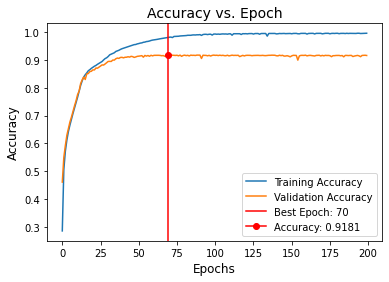

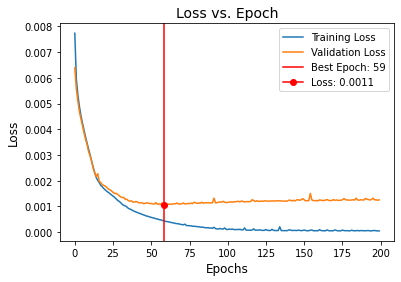

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 2000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 99.67
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
currGames = 2000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 91.66
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 8000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.90
Normalized confusion matrix


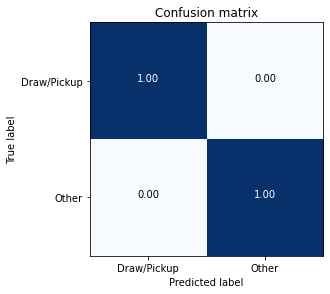

Confusion matrix, without normalization


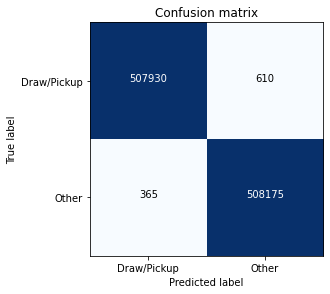

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 98.48
Normalized confusion matrix


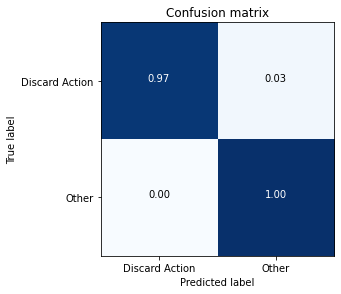

Confusion matrix, without normalization


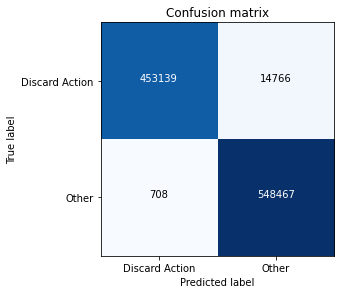

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 98.54
Normalized confusion matrix


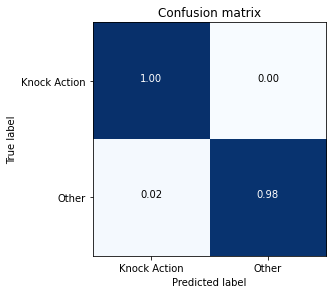

Confusion matrix, without normalization


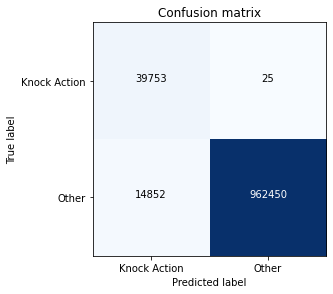

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

## all_states_all_actions_3HL_extra_knock_data_80K_2K_base

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_3hl_extra_knock_data_80K_2K_base'

# Number of Games
numGames = 2000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL', 'MLP_3HL'}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_3HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000},
                  'Third Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 40000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 2000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998
concatenating Third Path dataset (40000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 198987


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00810302 | Train acc: 0.181614
              Val Loss: 0.00758948 |   Val acc: 0.208657
Epoch: 2 | Train Loss: 0.00821627 | Train acc: 0.148188
              Val Loss: 0.00873393 |   Val acc: 0.092700
Epoch: 3 | Train Loss: 0.00797959 | Train acc: 0.198737
              Val Loss: 0.00733119 |   Val acc: 0.290136
Epoch: 4 | Train Loss: 0.00712404 | Train acc: 0.327570
              Val Loss: 0.00695404 |   Val acc: 0.365323
Epoch: 5 | Train Loss: 0.00659705 | Train acc: 0.410005
              Val Loss: 0.00644331 |   Val acc: 0.435617
Epoch: 6 | Train Loss: 0.00622338 | Train acc: 0.454751
              Val Loss: 0.00608379 |   Val acc: 0.474683
Epoch: 7 | Train Loss: 0.00586612 | Train acc: 0.499474
              Val Loss: 0.00570579 |   Val acc: 0.519117
Epoch: 8 | Train Loss: 0.00552447 | Train acc: 0.537285
              Val Loss: 0.00531896 |   Val acc: 0.556331
Epoch: 9 | Train Loss: 0.00521896 | Train acc: 0.566917
              Val Loss: 0.00517858 |   V

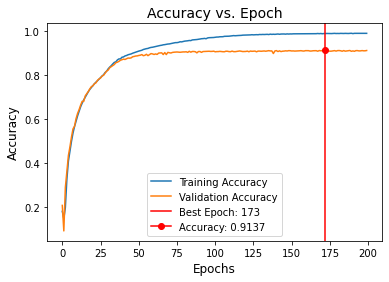

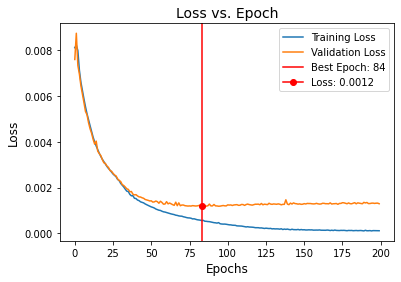

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 2000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 99.12
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
currGames = 2000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 91.26
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 8000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.95
Normalized confusion matrix


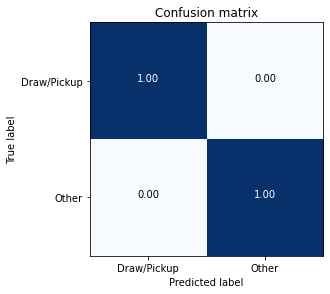

Confusion matrix, without normalization


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 98.66
Normalized confusion matrix


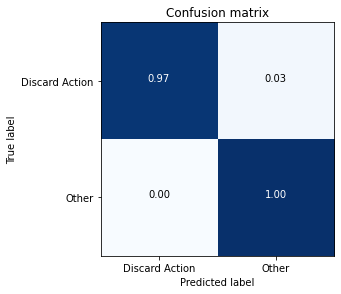

Confusion matrix, without normalization


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

knock
Accuracy: 98.65
Normalized confusion matrix


Confusion matrix, without normalization


## all_states_all_actions_3HL_extra_knock_data_80K

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_3hl_extra_knock_data_80K'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL', 'MLP_3HL'}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_3HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000},
                  'Third Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 40000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998
concatenating Third Path dataset (40000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 198987


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00834457 | Train acc: 0.149033
              Val Loss: 0.00904479 |   Val acc: 0.020110
Epoch: 2 | Train Loss: 0.00902386 | Train acc: 0.024631
              Val Loss: 0.00781460 |   Val acc: 0.244938
Epoch: 3 | Train Loss: 0.00652735 | Train acc: 0.328361
              Val Loss: 0.00647866 |   Val acc: 0.334855
Epoch: 4 | Train Loss: 0.00646210 | Train acc: 0.337852
              Val Loss: 0.00642436 |   Val acc: 0.341527
Epoch: 5 | Train Loss: 0.00642184 | Train acc: 0.342666
              Val Loss: 0.00638516 |   Val acc: 0.349863
Epoch: 6 | Train Loss: 0.00636553 | Train acc: 0.351441
              Val Loss: 0.00632855 |   Val acc: 0.362215
Epoch: 7 | Train Loss: 0.00622874 | Train acc: 0.389095
              Val Loss: 0.00616218 |   Val acc: 0.412779
Epoch: 8 | Train Loss: 0.00597505 | Train acc: 0.438991
              Val Loss: 0.00584615 |   Val acc: 0.458223
Epoch: 9 | Train Loss: 0.00569227 | Train acc: 0.483430
              Val Loss: 0.00552110 |   V

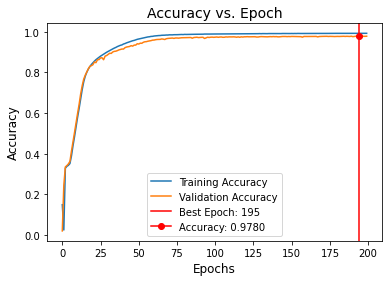

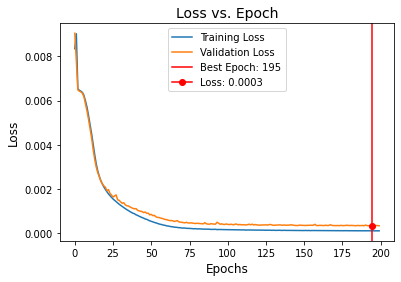

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 99.23
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 97.77
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 98.97
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 99.00
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 99.00
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 100.00
Normalized confusion matrix


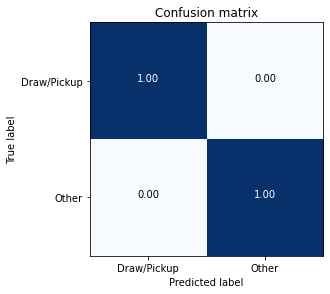

Confusion matrix, without normalization


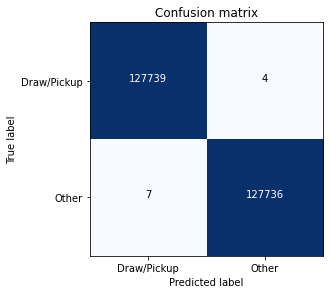

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.83
Normalized confusion matrix


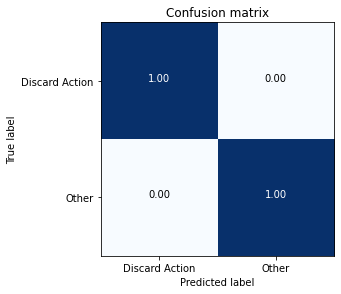

Confusion matrix, without normalization


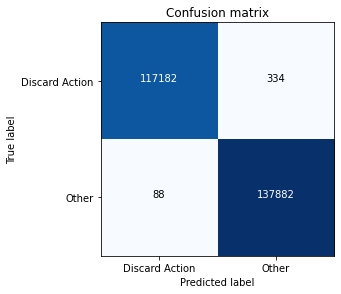

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

knock
Accuracy: 99.84
Normalized confusion matrix


Confusion matrix, without normalization


##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 98.09
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (6k)

In [ ]:
currGames = 6000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

loading 6000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 98.92
Normalized confusion matrix
Confusion matrix, without normalization


# All Additional Models

## all_states_all_actions_4HL_extra_knock_data_80K

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_4hl_extra_knock_data_80K'

# Number of Games
numGames = 8000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
lr = 0.001
epochs = 200

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL', 'MLP_3HL', 'MLP_4HL'}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_4HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000},
                  'Third Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 40000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 8000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998
concatenating Third Path dataset (40000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 198987


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00703348 | Train acc: 0.309858
              Val Loss: 0.00667044 |   Val acc: 0.320432
Epoch: 2 | Train Loss: 0.00655548 | Train acc: 0.318924
              Val Loss: 0.00651983 |   Val acc: 0.321657
Epoch: 3 | Train Loss: 0.00653300 | Train acc: 0.319432
              Val Loss: 0.00648518 |   Val acc: 0.322293
Epoch: 4 | Train Loss: 0.00649022 | Train acc: 0.321619
              Val Loss: 0.00644846 |   Val acc: 0.325292
Epoch: 5 | Train Loss: 0.00645220 | Train acc: 0.324372
              Val Loss: 0.00641028 |   Val acc: 0.327460
Epoch: 6 | Train Loss: 0.00639416 | Train acc: 0.328488
              Val Loss: 0.00632613 |   Val acc: 0.334452
Epoch: 7 | Train Loss: 0.00630268 | Train acc: 0.335808
              Val Loss: 0.00635599 |   Val acc: 0.330820
Epoch: 8 | Train Loss: 0.00622391 | Train acc: 0.343699
              Val Loss: 0.00613849 |   Val acc: 0.355286
Epoch: 9 | Train Loss: 0.00611870 | Train acc: 0.356466
              Val Loss: 0.00608148 |   V

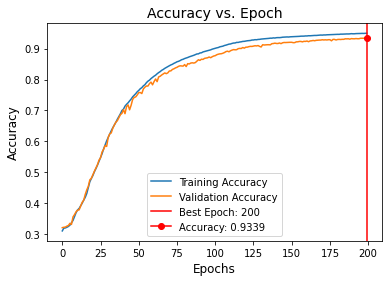

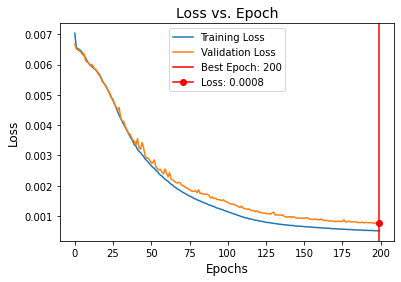

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 94.99
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
currGames = 8000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 93.39
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 97.87
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 97.87
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 97.87
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.99
Normalized confusion matrix


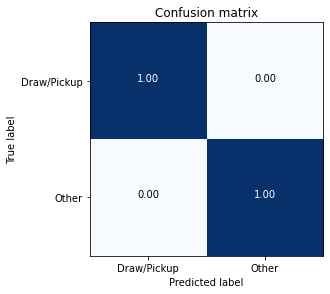

Confusion matrix, without normalization


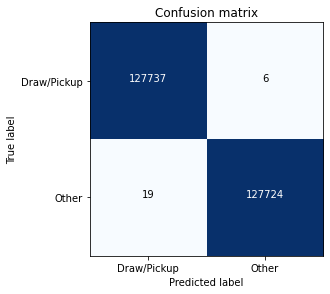

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.52
Normalized confusion matrix


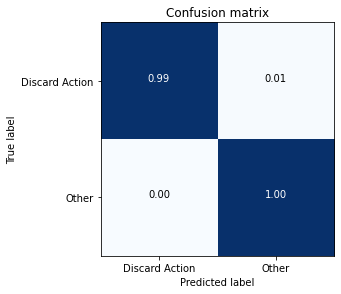

Confusion matrix, without normalization


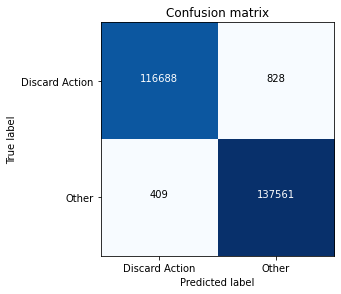

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.53
Normalized confusion matrix


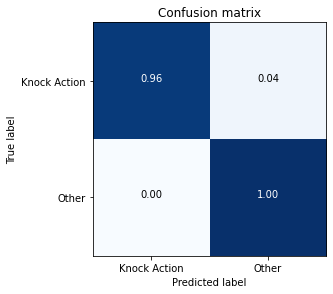

Confusion matrix, without normalization


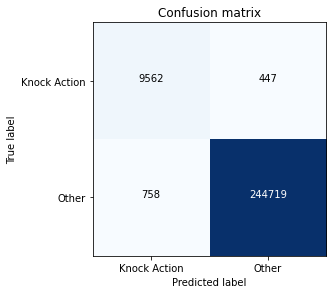

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 96.69
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (6k)

In [ ]:
currGames = 6000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

loading 6000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 87.04
Normalized confusion matrix
Confusion matrix, without normalization


## all_states_all_actions_4hl_extra_knock_data_160K_6K_base

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_4hl_extra_knock_data_160K_6K_base'

# Number of Games
numGames = 6000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
# lr = 0.001
lr = 0.0001
epochs = 400

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL', 'MLP_3HL', 'MLP_4HL'}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_4HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000},
                  'Third Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 40000},
                  'Forth Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 80000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

loading 6000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998
concatenating Third Path dataset (40000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 198987
concatenating Forth Path dataset (80000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 397966


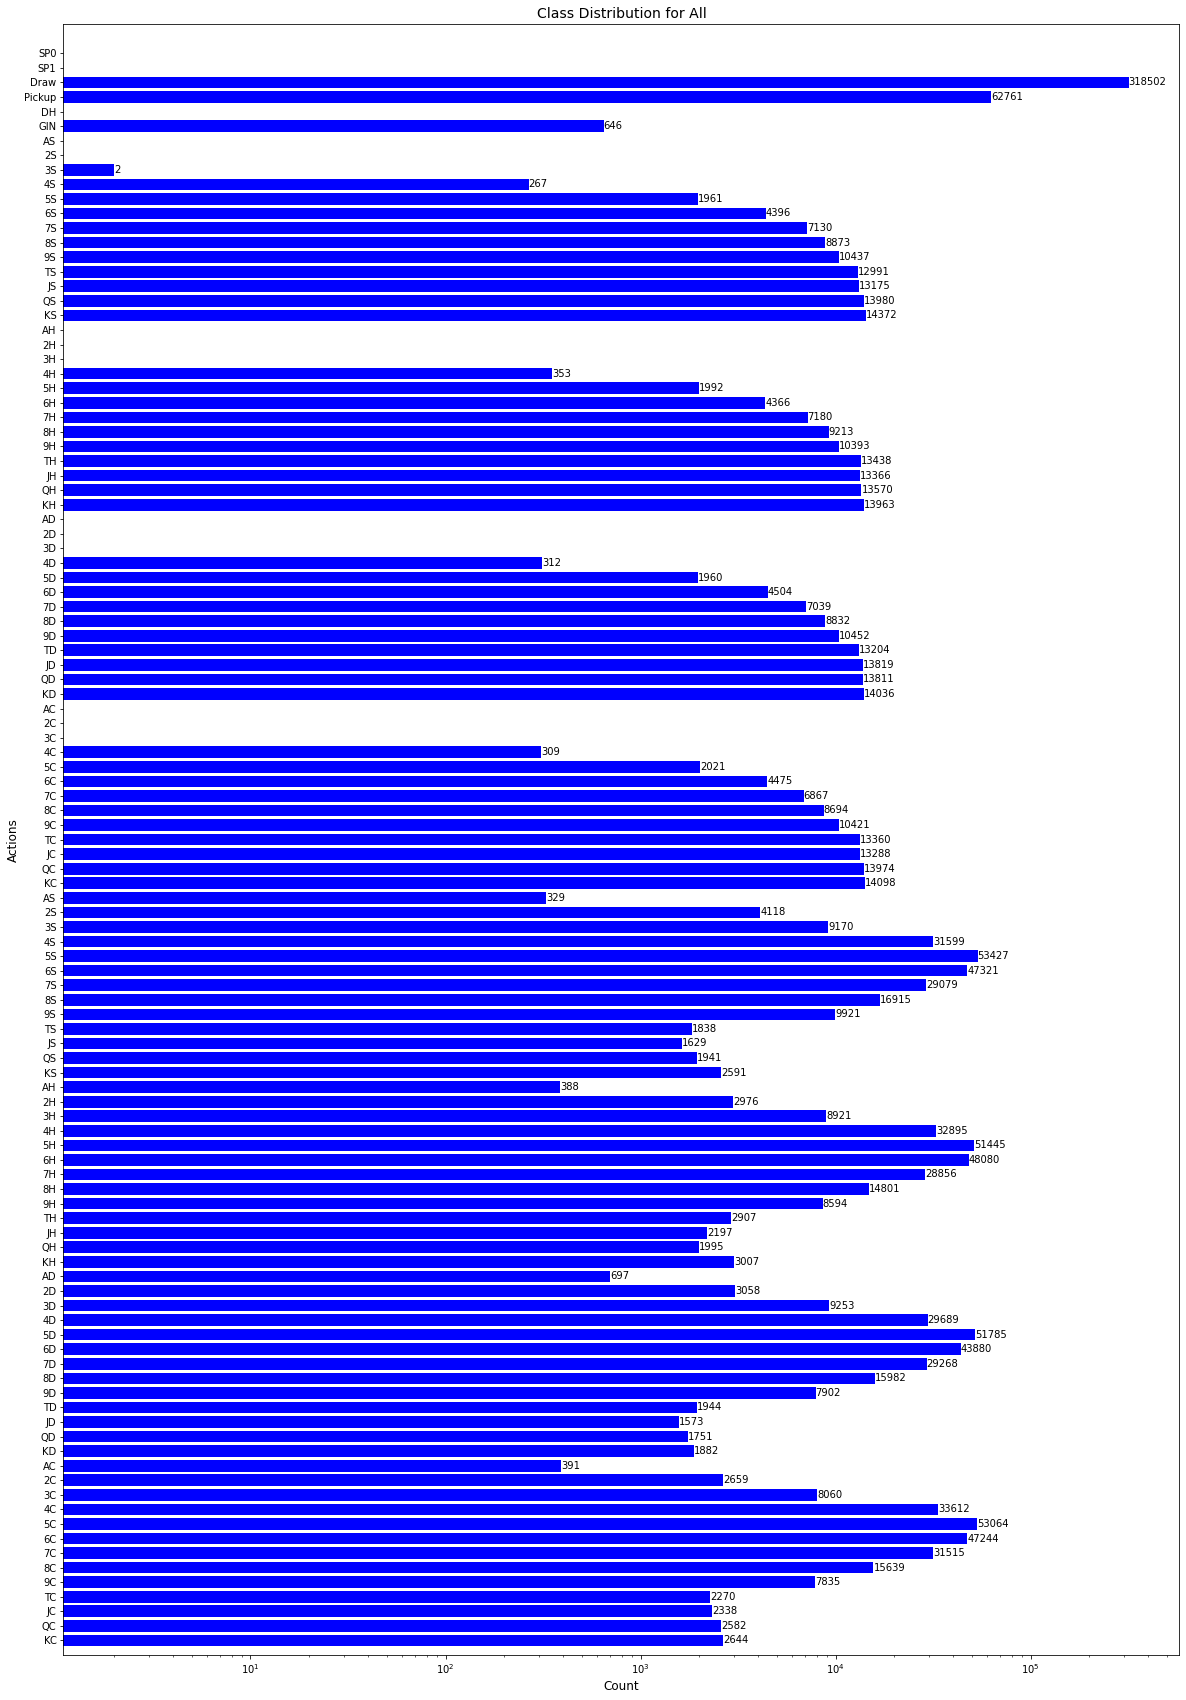

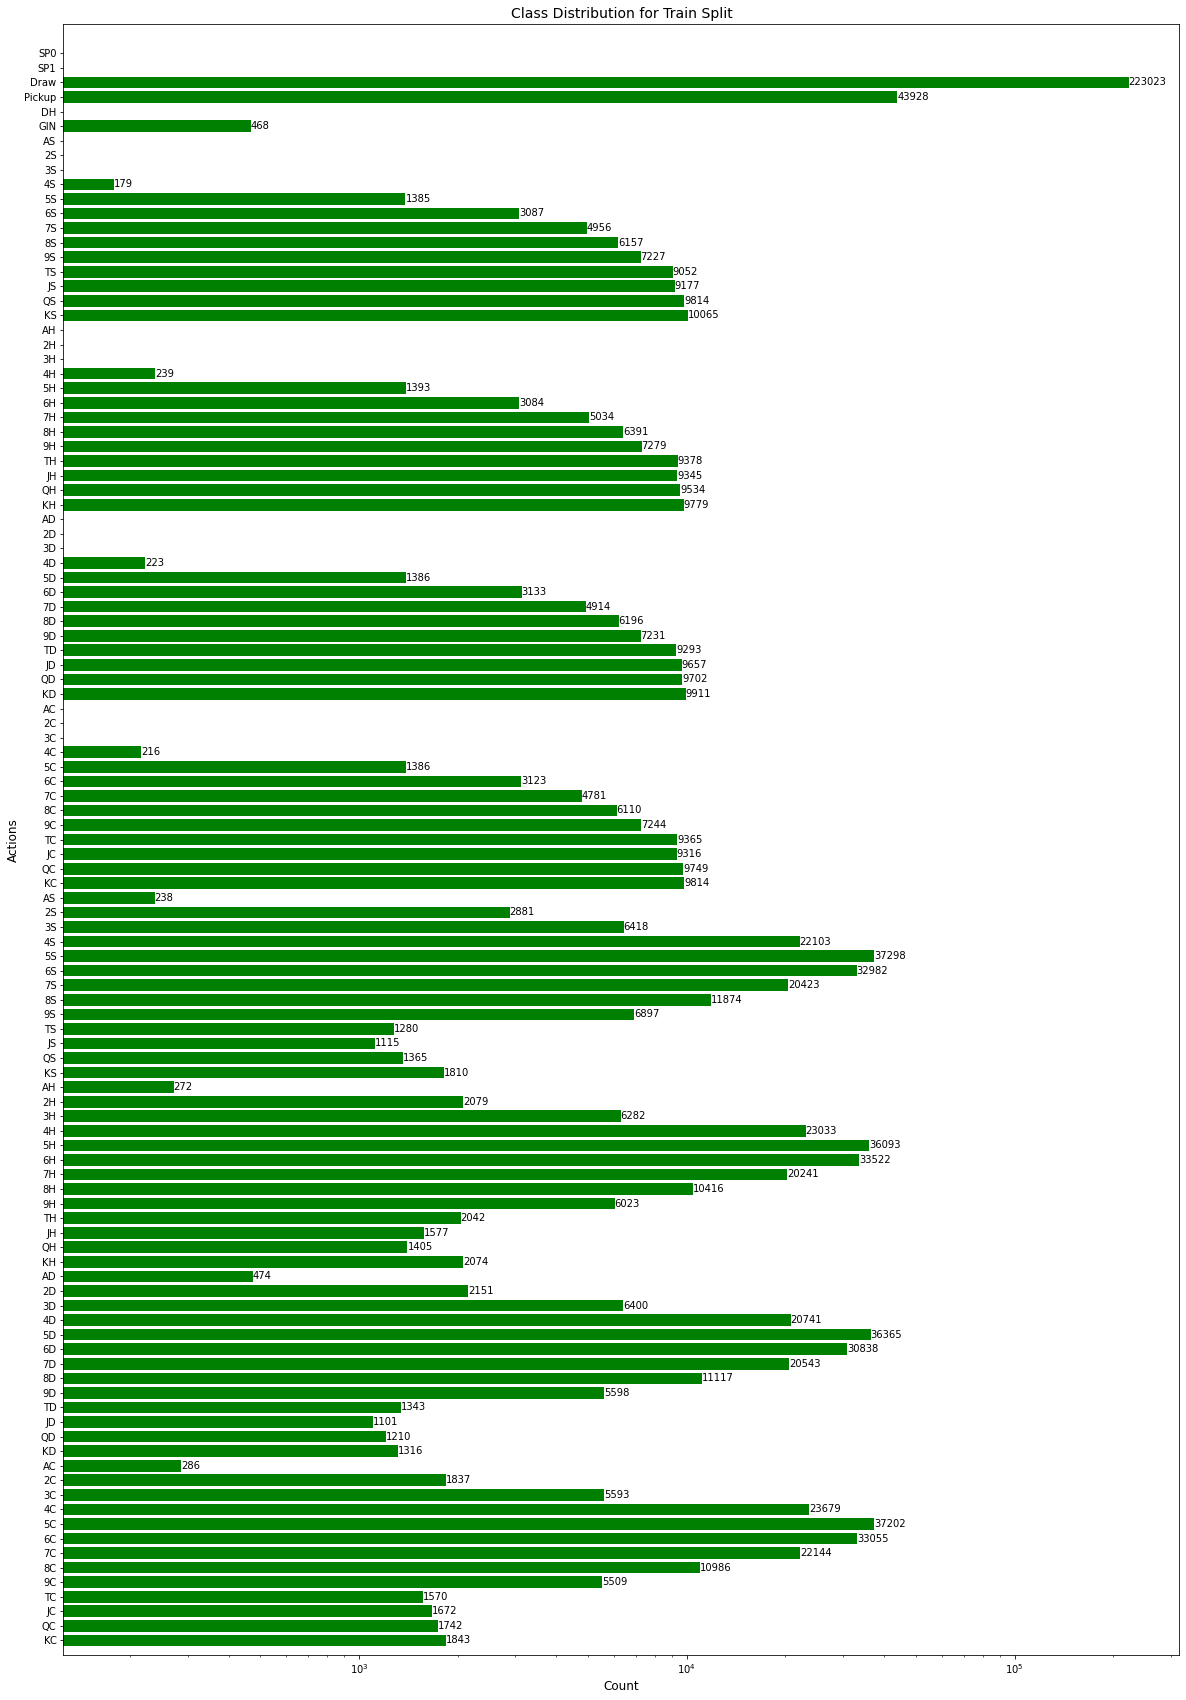

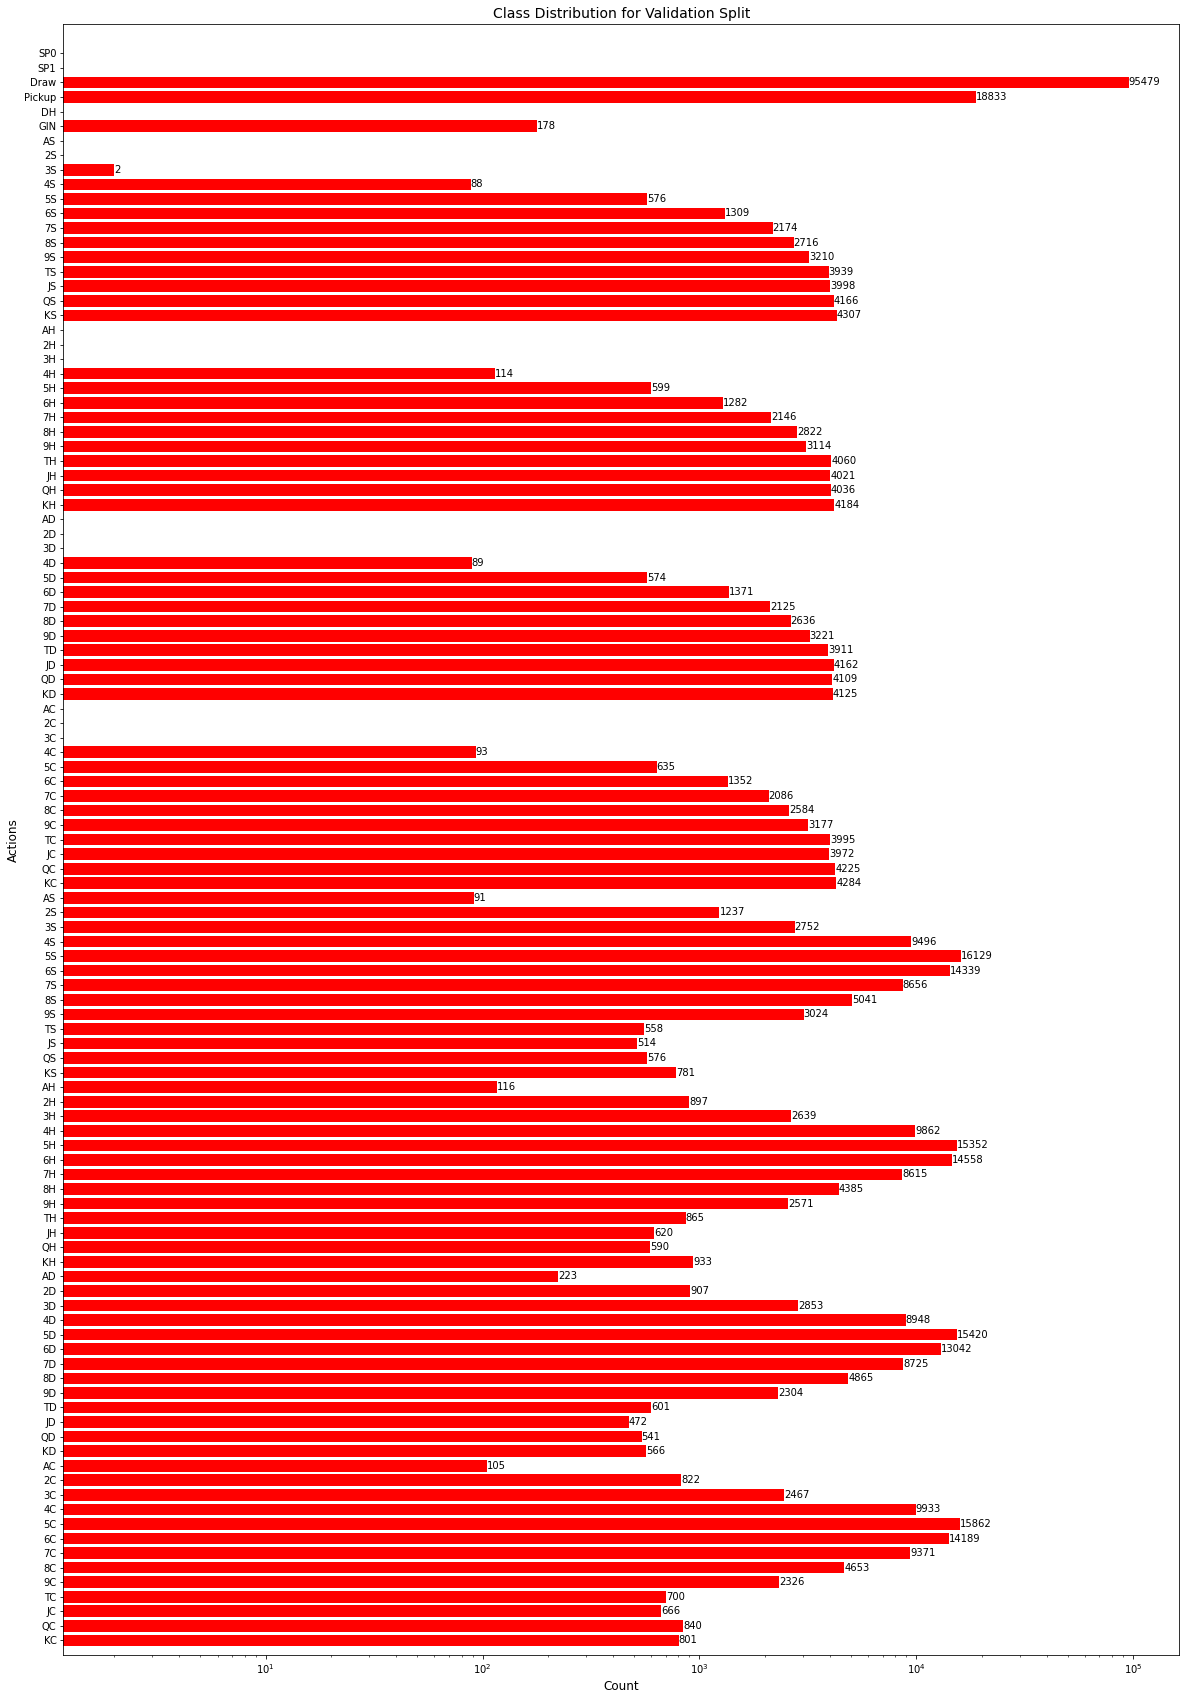

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=True)

### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00850969 | Train acc: 0.203483
              Val Loss: 0.00802999 |   Val acc: 0.211533
Epoch: 2 | Train Loss: 0.00734953 | Train acc: 0.234020
              Val Loss: 0.00727995 |   Val acc: 0.240572
Epoch: 3 | Train Loss: 0.00727606 | Train acc: 0.241281
              Val Loss: 0.00728090 |   Val acc: 0.245913
Epoch: 4 | Train Loss: 0.00725123 | Train acc: 0.257742
              Val Loss: 0.00722241 |   Val acc: 0.275346
Epoch: 5 | Train Loss: 0.00720450 | Train acc: 0.282552
              Val Loss: 0.00719005 |   Val acc: 0.290636
Epoch: 6 | Train Loss: 0.00718963 | Train acc: 0.289448
              Val Loss: 0.00719524 |   Val acc: 0.289710
Epoch: 7 | Train Loss: 0.00718201 | Train acc: 0.292078
              Val Loss: 0.00718526 |   Val acc: 0.291205
Epoch: 8 | Train Loss: 0.00717695 | Train acc: 0.293536
              Val Loss: 0.00718081 |   Val acc: 0.292057
Epoch: 9 | Train Loss: 0.00716997 | Train acc: 0.295350
              Val Loss: 0.00716317 |   V

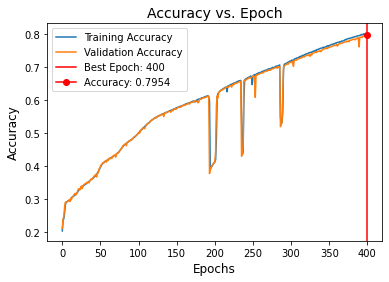

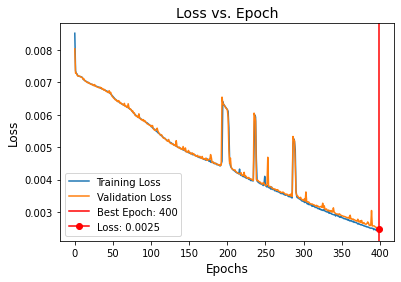

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 6000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 80.47
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
del train_loader

In [ ]:
currGames = 6000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 79.54
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 71.44
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 71.44
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 71.44
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.91
Normalized confusion matrix


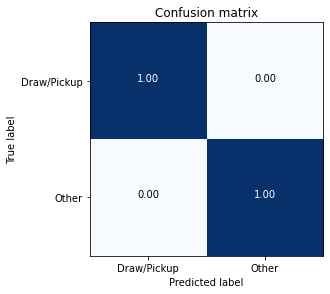

Confusion matrix, without normalization


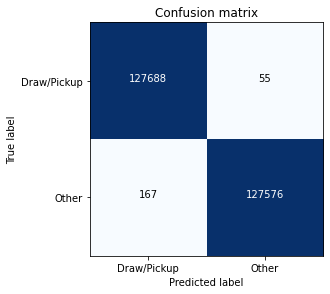

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 95.33
Normalized confusion matrix


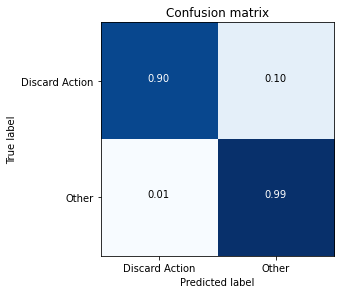

Confusion matrix, without normalization


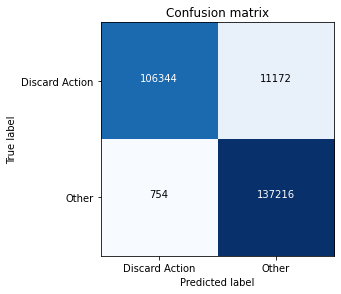

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 95.36
Normalized confusion matrix


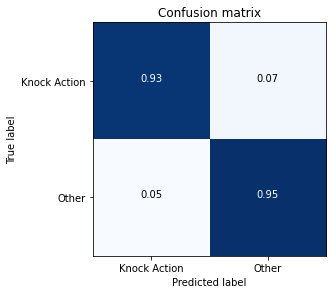

Confusion matrix, without normalization


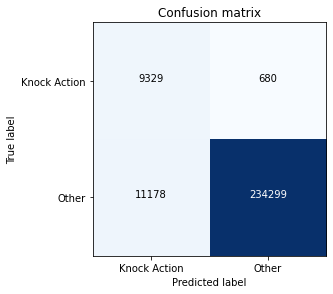

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 55.32
Normalized confusion matrix


##### Test Set - Knock Only (6k)

In [ ]:
currGames = 6000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

## all_states_all_actions_2hl_extra_knock_data_160K_6K_base

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_2hl_extra_knock_data_160K_6K_base'

# Number of Games
numGames = 6000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
# lr = 0.001
lr = 0.0001
epochs = 400

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL', 'MLP_3HL', 'MLP_4HL'}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_2HL'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000},
                  'Third Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 40000},
                  'Forth Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 80000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 6000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998
concatenating Third Path dataset (40000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 198987
concatenating Forth Path dataset (80000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 397966


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00846508 | Train acc: 0.204599
              Val Loss: 0.00823377 |   Val acc: 0.208425
Epoch: 2 | Train Loss: 0.00757625 | Train acc: 0.244825
              Val Loss: 0.00729985 |   Val acc: 0.308173
Epoch: 3 | Train Loss: 0.00714905 | Train acc: 0.323383
              Val Loss: 0.00693508 |   Val acc: 0.354753
Epoch: 4 | Train Loss: 0.00673499 | Train acc: 0.388794
              Val Loss: 0.00653500 |   Val acc: 0.421896
Epoch: 5 | Train Loss: 0.00636842 | Train acc: 0.448593
              Val Loss: 0.00624438 |   Val acc: 0.466041
Epoch: 6 | Train Loss: 0.00616595 | Train acc: 0.474652
              Val Loss: 0.00610407 |   Val acc: 0.480947
Epoch: 7 | Train Loss: 0.00604812 | Train acc: 0.487090
              Val Loss: 0.00600574 |   Val acc: 0.492087
Epoch: 8 | Train Loss: 0.00592997 | Train acc: 0.500465
              Val Loss: 0.00587130 |   Val acc: 0.507205
Epoch: 9 | Train Loss: 0.00578354 | Train acc: 0.519173
              Val Loss: 0.00571572 |   V

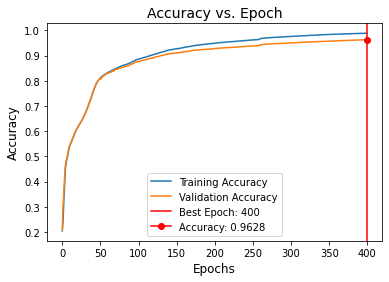

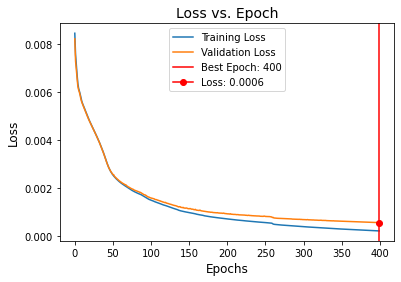

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 6000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 98.89
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
del train_loader

In [ ]:
currGames = 6000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 96.28
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 96.26
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 96.26
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 96.26
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.99
Normalized confusion matrix


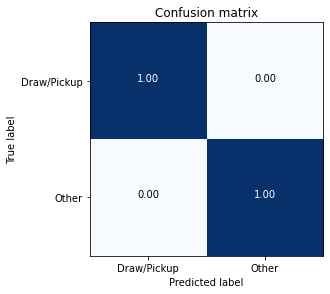

Confusion matrix, without normalization


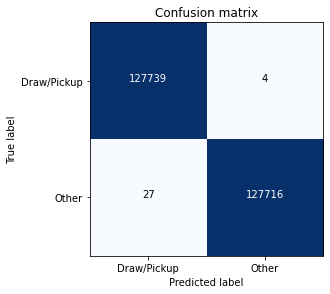

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.55
Normalized confusion matrix


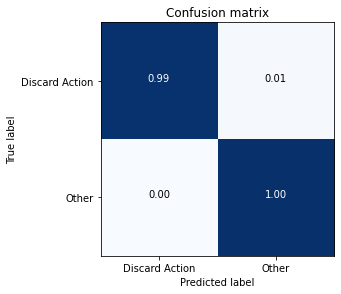

Confusion matrix, without normalization


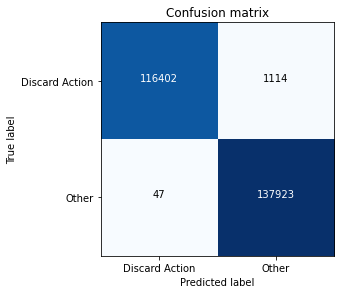

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.51
Normalized confusion matrix


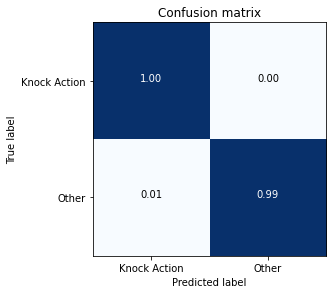

Confusion matrix, without normalization


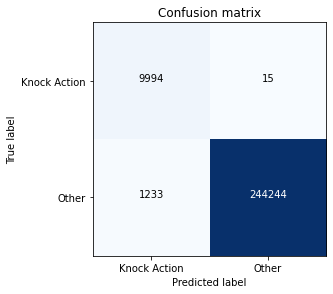

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 93.53
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (6k)

In [ ]:
currGames = 6000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

loading 6000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 99.78
Normalized confusion matrix
Confusion matrix, without normalization


## all_states_all_actions_4hl2_extra_knock_data_160K_6K_base

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_4hl2_extra_knock_data_160K_6K_base'

# Number of Games
numGames = 6000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
# lr = 0.001
lr = 0.0001
epochs = 400

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL', 'MLP_3HL', 'MLP_4HL', 'MLP_4HL2'}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_4HL2'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000},
                  'Third Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 40000},
                  'Forth Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 80000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 6000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998
concatenating Third Path dataset (40000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 198987
concatenating Forth Path dataset (80000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 397966


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00850972 | Train acc: 0.203134
              Val Loss: 0.00804667 |   Val acc: 0.210014
Epoch: 2 | Train Loss: 0.00735646 | Train acc: 0.233179
              Val Loss: 0.00728448 |   Val acc: 0.237190
Epoch: 3 | Train Loss: 0.00727715 | Train acc: 0.239798
              Val Loss: 0.00727172 |   Val acc: 0.240557
Epoch: 4 | Train Loss: 0.00727018 | Train acc: 0.245066
              Val Loss: 0.00726086 |   Val acc: 0.250679
Epoch: 5 | Train Loss: 0.00723006 | Train acc: 0.268007
              Val Loss: 0.00721557 |   Val acc: 0.275151
Epoch: 6 | Train Loss: 0.00719568 | Train acc: 0.285530
              Val Loss: 0.00718881 |   Val acc: 0.290508
Epoch: 7 | Train Loss: 0.00718568 | Train acc: 0.290128
              Val Loss: 0.00718075 |   Val acc: 0.289389
Epoch: 8 | Train Loss: 0.00717971 | Train acc: 0.292085
              Val Loss: 0.00718705 |   Val acc: 0.288157
Epoch: 9 | Train Loss: 0.00717624 | Train acc: 0.293409
              Val Loss: 0.00717166 |   V

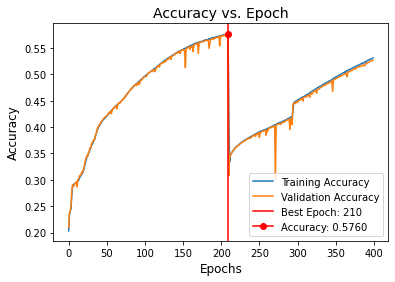

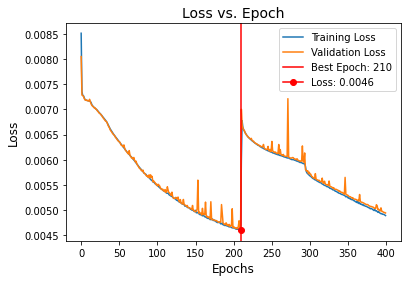

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 6000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 53.21
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
del train_loader

In [ ]:
currGames = 6000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 52.67
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 65.10
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 47.72
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 47.72
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 99.92
Normalized confusion matrix


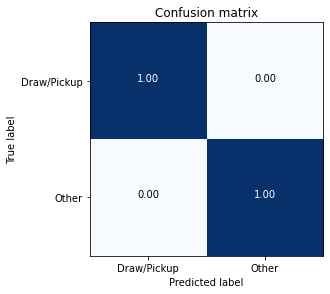

Confusion matrix, without normalization


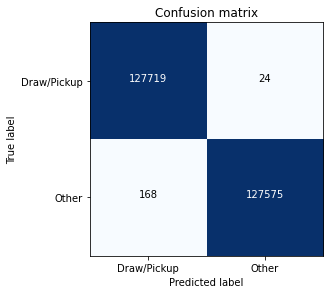

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 94.24
Normalized confusion matrix


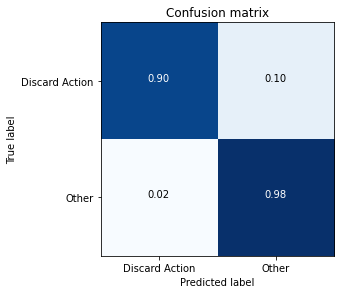

Confusion matrix, without normalization


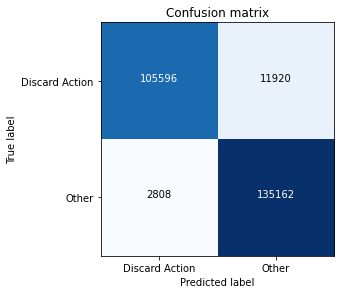

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 94.29
Normalized confusion matrix


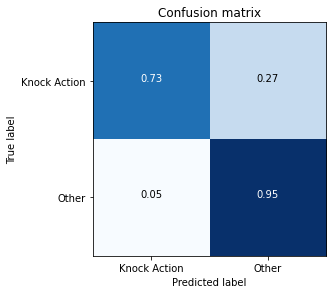

Confusion matrix, without normalization


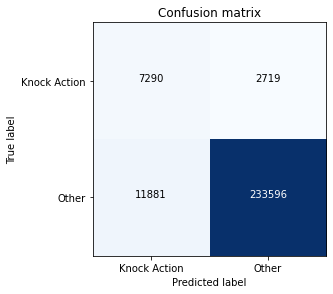

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 45.79
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (6k)

In [ ]:
currGames = 6000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

loading 6000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 41.88
Normalized confusion matrix
Confusion matrix, without normalization


## all_states_all_actions_2hl_wide_extra_knock_data_160K_6K_base

### Parameters

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_2hl_wide_extra_knock_data_160K_6K_base'

# Number of Games
numGames = 6000

# prunable states
# {'currHand','topCard','deadCard','oppCard','unknownCard'} or blank if None
pruneStatesList = []

# choosable actions
# {'all','draw_pickup','discard','knock','knock_bin'}
actionChoice = 'all'

# Balance classes
balance = False

# Training parameters
batch_size = 1000
# lr = 0.001
lr = 0.0001
epochs = 400

# choose model architecture, activation function
# {'MLP_base', 'MLP_2HL', 'MLP_3HL', 'MLP_4HL', 'MLP_4HL2', 'MLP_2HL_wide'}, {'sig', 'relu', 'tanh'}
model_fnc = 'MLP_2HL_wide'
activation = 'sig'

# Loss Function and Class Weights, either inverse class freq, or log icf
# {'MSE', 'CELoss'}, {None, 'icf', 'log_icf'}
loss = 'MSE'
loss_weight = None

# Pretrain model
pre_train = False
model_PT = ''

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# additional data paths
# multi_data_pth =  {'First Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                   'numGames': {number of games}},
#                    'Second Path': {'data_pth': {'pth'}/data/{'state'}/{'action'},
#                                    'numGames': {number of games}}
#                    ...}
# where state/action are legal state_action pairs
# ex. multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
#                                  'numGames': 8000}}
multi_data_pth = {'First Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 8000},
                  'Second Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 32000},
                  'Third Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 40000},
                  'Forth Path': {'data_pth': '{}/data/{}/{}'.format(pth,'apbd','knock'),
                                 'numGames': 80000}}

### Create Directories

In [ ]:
data_pth, model_pth, plot_pth = create_dir(pth, state, action, model_name)

Directories created.


### Load, Prune, and Split Training Data

In [ ]:
train_loader, val_loader, weights, classes = load_train_data(data_pth, plot_pth,
                                                             numGames, batch_size, 
                                                             pruneStatesList, actionChoice, 
                                                             balance, loss_weight, multi_data_pth,
                                                             visualize=False)

loading 6000 games dataset from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all"
concatenating First Path dataset (8000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 39783
concatenating Second Path dataset (32000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 158998
concatenating Third Path dataset (40000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 198987
concatenating Forth Path dataset (80000 games) from "/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock"
Number of rows added: 397966


### Train Model & Visualize Results

#### Train Model

In [ ]:
# Write Parameters
write_params(pth, state, action, 
             model_name, 
             numGames, 
             pruneStatesList, actionChoice, 
             balance, 
             batch_size, lr, epochs, 
             model_fnc, activation, 
             loss, loss_weight, 
             pre_train, model_PT, 
             device,
             multi_data_pth)

Parameters written.


Epoch: 1 | Train Loss: 0.00835380 | Train acc: 0.209386
              Val Loss: 0.00775398 |   Val acc: 0.214440
Epoch: 2 | Train Loss: 0.00723017 | Train acc: 0.308321
              Val Loss: 0.00688331 |   Val acc: 0.368430
Epoch: 3 | Train Loss: 0.00660711 | Train acc: 0.413235
              Val Loss: 0.00637524 |   Val acc: 0.454124
Epoch: 4 | Train Loss: 0.00623691 | Train acc: 0.468489
              Val Loss: 0.00614864 |   Val acc: 0.477691
Epoch: 5 | Train Loss: 0.00605169 | Train acc: 0.488982
              Val Loss: 0.00596919 |   Val acc: 0.499322
Epoch: 6 | Train Loss: 0.00585125 | Train acc: 0.514359
              Val Loss: 0.00575688 |   Val acc: 0.526622
Epoch: 7 | Train Loss: 0.00566533 | Train acc: 0.535420
              Val Loss: 0.00560179 |   Val acc: 0.539944
Epoch: 8 | Train Loss: 0.00554552 | Train acc: 0.547038
              Val Loss: 0.00550806 |   Val acc: 0.547996
Epoch: 9 | Train Loss: 0.00544747 | Train acc: 0.556117
              Val Loss: 0.00541190 |   V

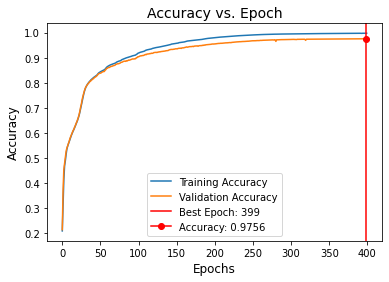

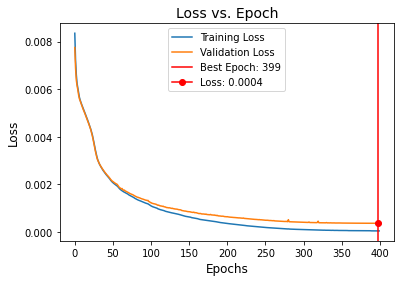

In [ ]:
model, model_acc, model_loss = train(train_loader, val_loader, plot_pth, batch_size, lr, epochs, verbose=True,
                                     model_fnc=model_fnc, activation=activation,
                                     loss=loss, weights=weights,
                                     pre_train=pre_train, model_PT=model_PT, device=device)
torch.save(model, '{}/model.pt'.format(model_pth))
torch.save(model_acc, '{}/model_acc.pt'.format(model_pth))
torch.save(model_loss, '{}/model_loss.pt'.format(model_pth))

#### Confusion Matrix

##### Load Models

In [ ]:
model = torch.load('{}/model.pt'.format(model_pth), map_location=device)
model_acc = torch.load('{}/model_acc.pt'.format(model_pth), map_location=device)
model_loss = torch.load('{}/model_loss.pt'.format(model_pth), map_location=device)

##### Train Set

In [ ]:
currGames = 6000
plot_cm(plot_pth, classes, model, train_loader, device, numGames=currGames)

Accuracy: 99.76
Normalized confusion matrix
Confusion matrix, without normalization


##### Validation Set

In [ ]:
del train_loader

In [ ]:
currGames = 6000
plot_cm(plot_pth, classes, model, val_loader, device, numGames=currGames, mode='val')

Accuracy: 97.56
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set (2k)

Test on all three models generated:

In [ ]:
currGames = 2000
test_loader_2k, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### all epoch

In [ ]:
plot_cm(plot_pth, classes, model, test_loader_2k, device, numGames=currGames)

Accuracy: 98.16
Normalized confusion matrix
Confusion matrix, without normalization


###### max validation accuracy

In [ ]:
plot_cm(plot_pth, classes, model_acc, test_loader_2k, device, numGames=currGames, mode='acc')

Accuracy: 98.17
Normalized confusion matrix
Confusion matrix, without normalization


###### min validation loss

In [ ]:
plot_cm(plot_pth, classes, model_loss, test_loader_2k, device, numGames=currGames, mode='loss')

Accuracy: 98.17
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Class Groups

Test on all three class groups:

```r
class_group = {'draw', 'discard', 'knock'}
```

In [ ]:
currGames = 2000
test_loader, classes = load_test_data(data_pth, currGames, 
                                         pruneStatesList, actionChoice)

loading 2000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/all/all


###### draw

draw
Accuracy: 100.00
Normalized confusion matrix


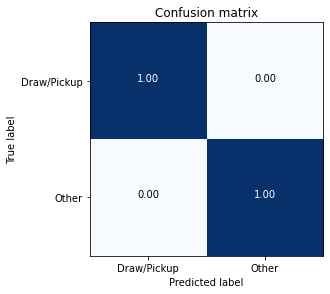

Confusion matrix, without normalization


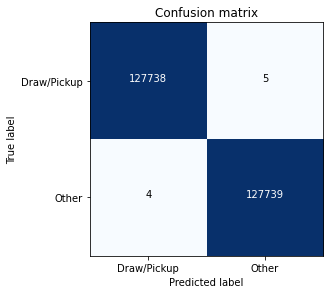

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='draw')

###### discard

discard
Accuracy: 99.74
Normalized confusion matrix


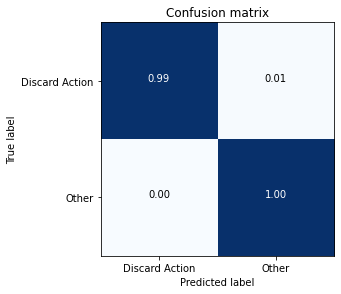

Confusion matrix, without normalization


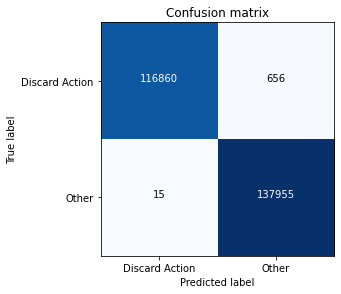

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='discard')

###### knock

knock
Accuracy: 99.72
Normalized confusion matrix


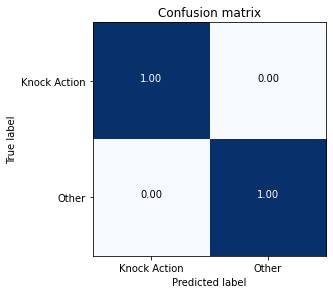

Confusion matrix, without normalization


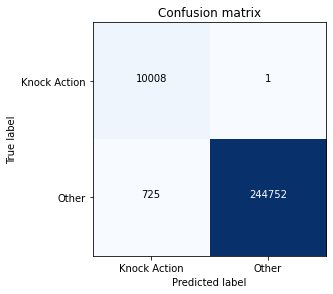

In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, class_group='knock')

##### Test Set - Discard Only (8k)

In [ ]:
currGames = 8000
data_pth_discard = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard'
test_loader, classes = load_test_data(data_pth_discard, currGames, 
                                         pruneStatesList, actionChoice)

loading 8000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/discard


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 97.10
Normalized confusion matrix
Confusion matrix, without normalization


##### Test Set - Knock Only (6k)

In [ ]:
currGames = 6000
data_pth_knock = '/content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock'
test_loader, classes = load_test_data(data_pth_knock, currGames, 
                                         pruneStatesList, actionChoice)

loading 6000 games dataset from /content/drive/MyDrive/Colab Notebooks/Thesis/data/apbd/knock


In [ ]:
plot_cm(plot_pth, classes, model, test_loader, device, numGames=currGames, mode='knock_data_only')

Accuracy: 99.95
Normalized confusion matrix
Confusion matrix, without normalization
